Finding CBC parameter itemids...
Found CBC-related lab items:
     itemid                                 label    category
0     52170                                   Rbc  Hematology
1     50852                      % Hemoglobin A1c   Chemistry
2     52069               Absolute Basophil Count  Hematology
3     52073             Absolute Eosinophil Count  Hematology
4     50855                   Absolute Hemoglobin   Chemistry
5     51133             Absolute Lymphocyte Count  Hematology
6     53157             Absolute Lymphocyte Count   Chemistry
7     52769             Absolute Lymphocyte Count  Hematology
8     52074               Absolute Monocyte Count  Hematology
9     53159             Absolute Neutrophil Count   Chemistry
10    52075             Absolute Neutrophil Count  Hematology
11    50872  Anti-Neutrophil Cytoplasmic Antibody   Chemistry
12    51110                  Atypical Lymphocytes  Hematology
13    51143                  Atypical Lymphocytes  Hematology
14    51

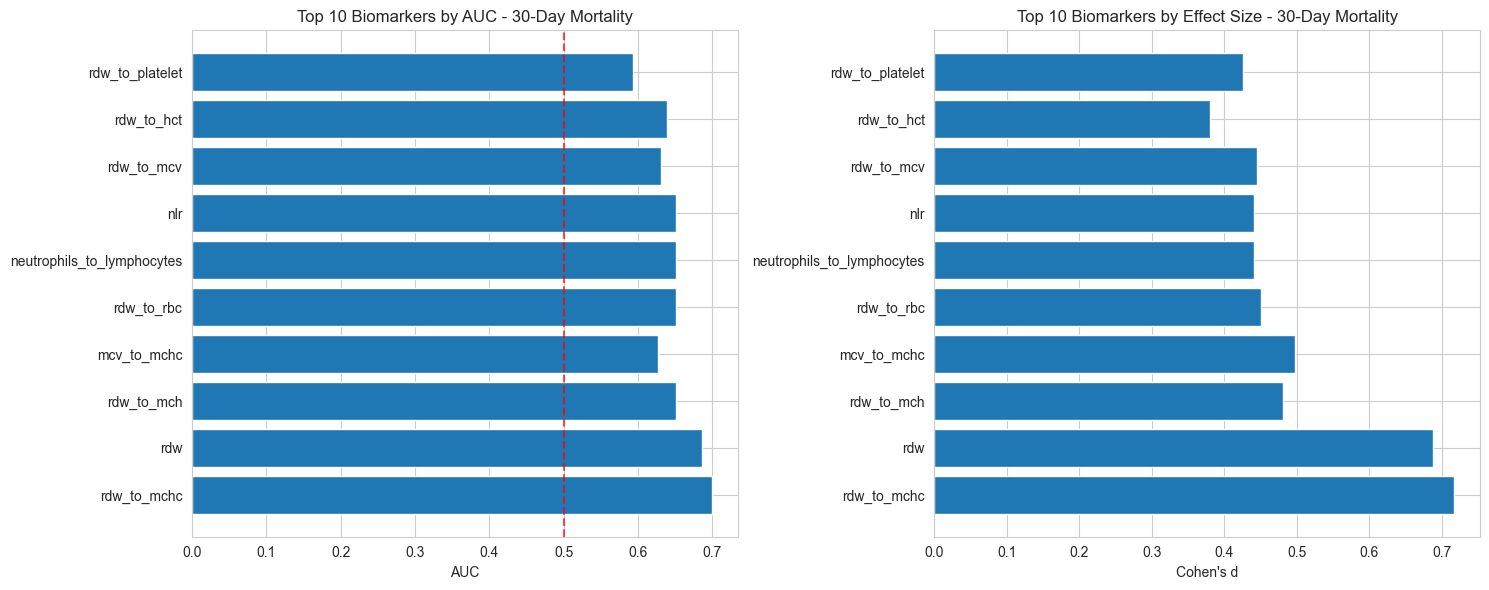

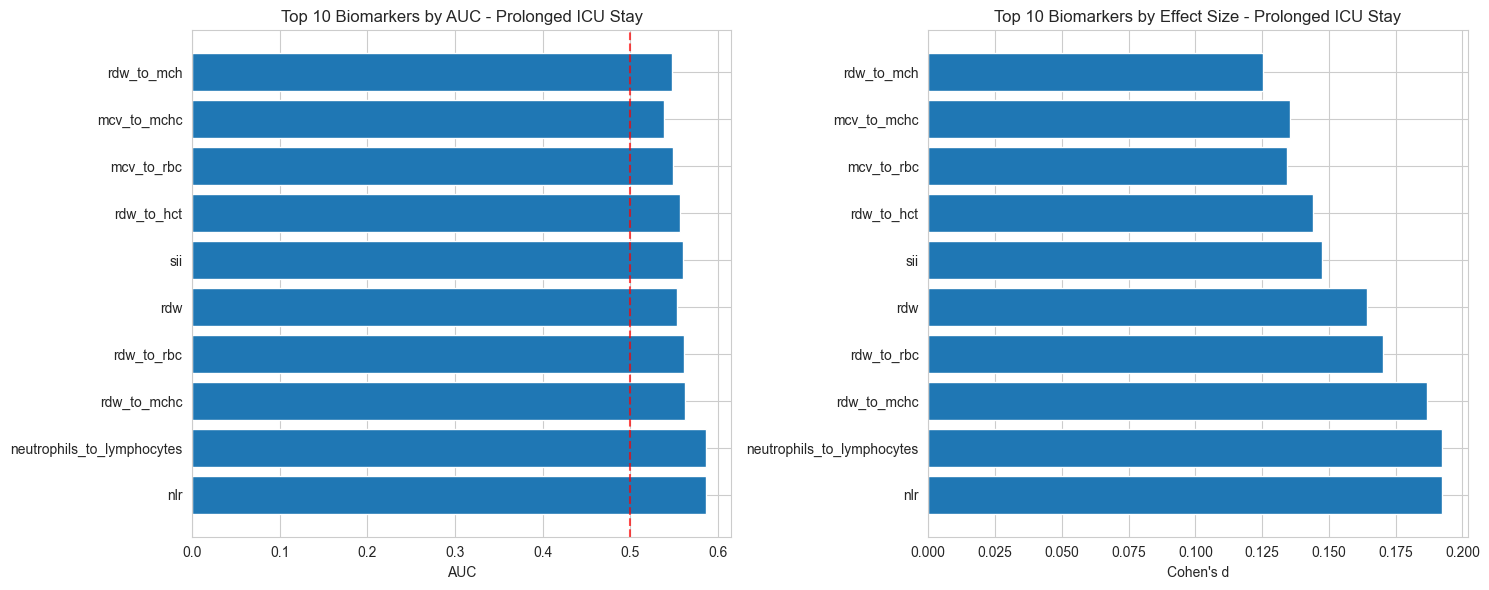

In [2]:
import duckdb
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr, mannwhitneyu, spearmanr
from itertools import combinations, permutations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# ─── 1) CONNECT & SETUP (using your existing framework) ─────────────────
con = duckdb.connect()

from pathlib import Path
DATA_DIR = Path("/Users/dimitri/Desktop/indi/data/mimic-iv-3.1")
p = lambda f: str(DATA_DIR / f)

# Your existing views (patients, icustays, diagnoses, etc.)
con.execute(f"""
CREATE OR REPLACE VIEW patients AS
SELECT subject_id, anchor_year, anchor_year_group, dod
FROM read_csv_auto('{p('hosp/patients.csv.gz')}');
""")

con.execute(f"""
CREATE OR REPLACE VIEW icustays AS
SELECT subject_id, hadm_id, stay_id, intime, outtime,
       EXTRACT(epoch FROM (outtime - intime))/3600 AS los_hours
FROM read_csv_auto('{p('icu/icustays.csv.gz')}');
""")

# ─── 2) FIND CORRECT CBC ITEMIDS FROM D_LABITEMS ─────────────────────────
con.execute(f"""
CREATE OR REPLACE VIEW d_labitems AS
SELECT itemid, label, fluid, category
FROM read_csv_auto('{p('hosp/d_labitems.csv')}');
""")

# Find CBC-related itemids by searching labels
print("Finding CBC parameter itemids...")
cbc_itemids = con.execute("""
SELECT itemid, label, category
FROM d_labitems
WHERE LOWER(label) LIKE '%hemoglobin%' 
   OR LOWER(label) LIKE '%hematocrit%'
   OR LOWER(label) LIKE '%red blood cell%'
   OR LOWER(label) LIKE '%white blood cell%'
   OR LOWER(label) LIKE '%platelet%'
   OR LOWER(label) LIKE '%neutrophil%'
   OR LOWER(label) LIKE '%lymphocyte%'
   OR LOWER(label) LIKE '%monocyte%'
   OR LOWER(label) LIKE '%eosinophil%'
   OR LOWER(label) LIKE '%basophil%'
   OR LOWER(label) LIKE '%mcv%'
   OR LOWER(label) LIKE '%mch%'
   OR LOWER(label) LIKE '%mchc%'
   OR LOWER(label) LIKE '%rdw%'
   OR LOWER(label) LIKE '%rbc%'
   OR LOWER(label) LIKE '%wbc%'
   OR label ILIKE '%mean corpuscular%'
   OR label ILIKE '%red cell distribution%'
ORDER BY label;
""").df()

print("Found CBC-related lab items:")
print(cbc_itemids.to_string())

# Create a more robust CBC data extraction using found itemids
# You'll need to update these based on your actual d_labitems.csv content
con.execute(f"""
CREATE OR REPLACE TABLE enhanced_cbc AS
WITH cbc_labs AS (
  SELECT 
    l.hadm_id, l.charttime, l.itemid, l.valuenum,
    d.label, d.category
  FROM read_csv_auto('{p('hosp/labevents.csv.gz')}') AS l
  JOIN d_labitems d USING(itemid)
  WHERE d.itemid IN (
    SELECT itemid FROM d_labitems
    WHERE LOWER(label) LIKE '%hemoglobin%' 
       OR LOWER(label) LIKE '%hematocrit%'
       OR LOWER(label) LIKE '%red blood cell%'
       OR LOWER(label) LIKE '%white blood cell%'
       OR LOWER(label) LIKE '%platelet%'
       OR LOWER(label) LIKE '%neutrophil%'
       OR LOWER(label) LIKE '%lymphocyte%'
       OR LOWER(label) LIKE '%monocyte%'
       OR LOWER(label) LIKE '%mcv%'
       OR LOWER(label) LIKE '%mch%'
       OR LOWER(label) LIKE '%mchc%'
       OR LOWER(label) LIKE '%rdw%'
       OR LOWER(label) LIKE '%rbc%'
       OR LOWER(label) LIKE '%wbc%'
       OR label ILIKE '%mean corpuscular%'
       OR label ILIKE '%red cell distribution%'
  )
)
SELECT
  i.stay_id, i.hadm_id, i.los_hours,
  -- Use label-based matching for robustness
  MIN(CASE WHEN LOWER(c.label) LIKE '%hemoglobin%' AND LOWER(c.label) NOT LIKE '%mean%' 
           THEN c.valuenum END) AS hb,
  MIN(CASE WHEN LOWER(c.label) LIKE '%hematocrit%' 
           THEN c.valuenum END) AS hct,
  MIN(CASE WHEN LOWER(c.label) LIKE '%mcv%' OR c.label ILIKE '%mean corpuscular volume%'
           THEN c.valuenum END) AS mcv,
  MIN(CASE WHEN LOWER(c.label) LIKE '%mch%' AND LOWER(c.label) NOT LIKE '%mchc%'
           THEN c.valuenum END) AS mch,
  MIN(CASE WHEN LOWER(c.label) LIKE '%mchc%' 
           THEN c.valuenum END) AS mchc,
  MIN(CASE WHEN LOWER(c.label) LIKE '%rdw%' OR c.label ILIKE '%red cell distribution%'
           THEN c.valuenum END) AS rdw,
  MIN(CASE WHEN (LOWER(c.label) LIKE '%red blood cell%' OR LOWER(c.label) LIKE '%rbc%') 
           AND LOWER(c.label) NOT LIKE '%distribution%'
           THEN c.valuenum END) AS rbc,
  MIN(CASE WHEN LOWER(c.label) LIKE '%platelet%' AND LOWER(c.label) NOT LIKE '%mean%'
           THEN c.valuenum END) AS platelet,
  MIN(CASE WHEN (LOWER(c.label) LIKE '%white blood cell%' OR LOWER(c.label) LIKE '%wbc%')
           AND LOWER(c.label) NOT LIKE '%differential%'
           THEN c.valuenum END) AS wbc,
  MIN(CASE WHEN LOWER(c.label) LIKE '%neutrophil%' 
           THEN c.valuenum END) AS neutrophils,
  MIN(CASE WHEN LOWER(c.label) LIKE '%lymphocyte%' 
           THEN c.valuenum END) AS lymphocytes,
  MIN(CASE WHEN LOWER(c.label) LIKE '%monocyte%' 
           THEN c.valuenum END) AS monocytes,
  MIN(CASE WHEN LOWER(c.label) LIKE '%eosinophil%' 
           THEN c.valuenum END) AS eosinophils,
  MIN(CASE WHEN LOWER(c.label) LIKE '%basophil%' 
           THEN c.valuenum END) AS basophils,
  -- Outcomes
  CASE WHEN p.dod IS NOT NULL AND p.dod <= i.outtime + INTERVAL '30' DAY 
       THEN 1 ELSE 0 END AS mort_30d,
  CASE WHEN i.los_hours > 72 THEN 1 ELSE 0 END AS prolonged_stay
FROM cbc_labs c
JOIN icustays i USING(hadm_id)
JOIN patients p USING(subject_id)
WHERE c.charttime BETWEEN i.intime AND i.intime + INTERVAL '24' HOUR
  AND c.valuenum IS NOT NULL 
  AND c.valuenum > 0  -- Remove invalid/zero values
GROUP BY i.stay_id, i.hadm_id, i.los_hours, p.dod, i.outtime;
""")

# ─── 3) RATIO EXPLORATION FUNCTIONS ─────────────────────────────────────
def create_ratio_biomarkers(df, base_params):
    """Create systematic ratio combinations from CBC parameters"""
    ratio_df = df.copy()
    
    # 2-parameter ratios (all combinations)
    for param1, param2 in combinations(base_params, 2):
        if param1 in df.columns and param2 in df.columns:
            # Forward ratio
            ratio_df[f'{param1}_to_{param2}'] = df[param1] / (df[param2] + 1e-8)
            # Reverse ratio  
            ratio_df[f'{param2}_to_{param1}'] = df[param2] / (df[param1] + 1e-8)
    
    # Known inflammatory indices
    if all(col in df.columns for col in ['neutrophils', 'lymphocytes']):
        ratio_df['nlr'] = df['neutrophils'] / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['platelet', 'lymphocytes']):
        ratio_df['plr'] = df['platelet'] / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['monocytes', 'lymphocytes']):
        ratio_df['mlr'] = df['monocytes'] / (df['lymphocytes'] + 1e-8)
    
    # Novel multi-parameter indices
    if all(col in df.columns for col in ['neutrophils', 'monocytes', 'lymphocytes']):
        ratio_df['siri'] = (df['neutrophils'] * df['monocytes']) / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['neutrophils', 'platelet', 'lymphocytes']):
        ratio_df['sii'] = (df['neutrophils'] * df['platelet']) / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['hb', 'rdw']):
        ratio_df['hrr'] = df['hb'] / (df['rdw'] + 1e-8)
    
    if all(col in df.columns for col in ['wbc', 'hb']):
        ratio_df['whr'] = df['wbc'] / (df['hb'] + 1e-8)
    
    # 3-parameter combinations (selective)
    if all(col in df.columns for col in ['hb', 'wbc', 'platelet']):
        ratio_df['hwp_index'] = (df['hb'] * df['wbc']) / (df['platelet'] + 1e-8)
        ratio_df['composite_blood'] = (df['hb'] + df['wbc'] + df['platelet']) / 3
    
    # RBC-related composite
    if all(col in df.columns for col in ['rbc', 'hb', 'hct']):
        ratio_df['rbc_composite'] = (df['rbc'] * df['hb']) / (df['hct'] + 1e-8)
    
    return ratio_df

def evaluate_biomarker_performance(df, biomarker_cols, outcome_col):
    """Evaluate biomarker performance against binary outcomes"""
    results = []
    
    for biomarker in biomarker_cols:
        if biomarker not in df.columns:
            continue
            
        # Clean data
        clean_data = df[[biomarker, outcome_col]].dropna()
        clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(clean_data) < 50 or clean_data[outcome_col].nunique() < 2:
            continue
        
        # Statistical tests
        try:
            # Point-biserial correlation
            r_pb, p_pb = pointbiserialr(clean_data[outcome_col], clean_data[biomarker])
            
            # Mann-Whitney U test
            group_0 = clean_data[clean_data[outcome_col] == 0][biomarker]
            group_1 = clean_data[clean_data[outcome_col] == 1][biomarker]
            u_stat, p_mw = mannwhitneyu(group_1, group_0, alternative='two-sided')
            
            # AUC
            auc = roc_auc_score(clean_data[outcome_col], clean_data[biomarker])
            
            # Effect size (Cohen's d approximation)
            mean_0, mean_1 = group_0.mean(), group_1.mean()
            pooled_std = np.sqrt(((len(group_0)-1)*group_0.var() + (len(group_1)-1)*group_1.var()) / (len(group_0)+len(group_1)-2))
            cohens_d = abs(mean_1 - mean_0) / (pooled_std + 1e-8)
            
            results.append({
                'biomarker': biomarker,
                'n_samples': len(clean_data),
                'outcome_rate': clean_data[outcome_col].mean(),
                'r_pointbiserial': r_pb,
                'p_pointbiserial': p_pb,
                'p_mannwhitney': p_mw,
                'auc': auc,
                'cohens_d': cohens_d,
                'mean_outcome_0': mean_0,
                'mean_outcome_1': mean_1
            })
            
        except Exception as e:
            print(f"Error processing {biomarker}: {e}")
            continue
    
    return pd.DataFrame(results)

def rank_biomarkers(results_df, criteria=['auc', 'cohens_d', 'r_pointbiserial']):
    """Rank biomarkers by multiple criteria"""
    if len(results_df) == 0:
        return results_df
    
    # Create composite score
    score_components = []
    for criterion in criteria:
        if criterion in results_df.columns:
            # Normalize to 0-1 scale
            normalized = (results_df[criterion] - results_df[criterion].min()) / (results_df[criterion].max() - results_df[criterion].min() + 1e-8)
            score_components.append(normalized)
    
    if score_components:
        results_df['composite_score'] = np.mean(score_components, axis=0)
        results_df = results_df.sort_values('composite_score', ascending=False)
    
    return results_df

# ─── 4) DATA VALIDATION AND DEBUGGING ─────────────────────────────────────
print("Checking data extraction...")
data_summary = con.execute("""
    SELECT 
        COUNT(*) as total_rows,
        COUNT(DISTINCT stay_id) as unique_stays,
        COUNT(hb) as has_hb,
        COUNT(hct) as has_hct,
        COUNT(wbc) as has_wbc,
        COUNT(platelet) as has_platelet,
        AVG(hb) as avg_hb,
        AVG(hct) as avg_hct,
        AVG(wbc) as avg_wbc,
        AVG(platelet) as avg_platelet
    FROM enhanced_cbc
""").df()

print("Data summary:")
print(data_summary.to_string())

# Check for any obvious data issues
print("\nChecking for extreme values...")
extreme_check = con.execute("""
    SELECT 
        MIN(hb) as min_hb, MAX(hb) as max_hb,
        MIN(hct) as min_hct, MAX(hct) as max_hct,
        MIN(wbc) as min_wbc, MAX(wbc) as max_wbc,
        MIN(platelet) as min_platelet, MAX(platelet) as max_platelet
    FROM enhanced_cbc
    WHERE hb IS NOT NULL OR hct IS NOT NULL OR wbc IS NOT NULL OR platelet IS NOT NULL
""").df()

print(extreme_check.to_string())

# ─── 5) EXECUTE RATIO EXPLORATION ──────────────────────────────────────
# Check data availability first
print("\nChecking CBC data availability...")
data_check = con.execute("""
    SELECT 
        COUNT(*) as total_stays,
        COUNT(hb) as has_hb,
        COUNT(hct) as has_hct,
        COUNT(wbc) as has_wbc,
        COUNT(platelet) as has_platelet,
        COUNT(rbc) as has_rbc,
        COUNT(neutrophils) as has_neutrophils,
        COUNT(lymphocytes) as has_lymphocytes,
        COUNT(monocytes) as has_monocytes,
        COUNT(mcv) as has_mcv,
        COUNT(mch) as has_mch,
        COUNT(mchc) as has_mchc,
        COUNT(rdw) as has_rdw
    FROM enhanced_cbc
""").df()

print("Data availability:")
for col in data_check.columns:
    if col != 'total_stays':
        pct = (data_check[col].iloc[0] / data_check['total_stays'].iloc[0]) * 100 if data_check['total_stays'].iloc[0] > 0 else 0
        print(f"  {col}: {data_check[col].iloc[0]} ({pct:.1f}%)")

# Pull data with reasonable completeness requirement
print("\nLoading CBC data...")
df_main = con.execute("""
    SELECT stay_id, hadm_id, 
           hb, hct, mcv, mch, mchc, rdw, rbc, 
           platelet, wbc, neutrophils, lymphocytes, monocytes, eosinophils, basophils,
           mort_30d, prolonged_stay, los_hours
    FROM enhanced_cbc
    WHERE ((hb IS NULL)::INT + (hct IS NULL)::INT + (wbc IS NULL)::INT + 
           (platelet IS NULL)::INT + (rbc IS NULL)::INT) <= 2
      AND (hb > 0 OR hct > 0 OR wbc > 0)  -- At least one valid CBC component
""").df()

print(f"Dataset: {len(df_main)} ICU stays")
if len(df_main) == 0:
    print("ERROR: No data found! Please check your itemids and data extraction.")
    exit()

print(f"30-day mortality rate: {df_main['mort_30d'].mean():.1%}")
print(f"Prolonged stay rate: {df_main['prolonged_stay'].mean():.1%}")

# Define base CBC parameters
base_cbc_params = ['hb', 'hct', 'mcv', 'mch', 'mchc', 'rdw', 'rbc', 
                   'platelet', 'wbc', 'neutrophils', 'lymphocytes', 'monocytes']

# Create ratio biomarkers
print("\nCreating ratio biomarkers...")
df_with_ratios = create_ratio_biomarkers(df_main, base_cbc_params)

# Get all ratio columns
ratio_cols = [col for col in df_with_ratios.columns 
              if ('_to_' in col or col in ['nlr', 'plr', 'mlr', 'siri', 'sii', 'hrr', 'whr', 
                                          'hwp_index', 'composite_blood', 'rbc_composite'])]

print(f"Created {len(ratio_cols)} ratio biomarkers")

# ─── 6) EVALUATE AGAINST OUTCOMES ──────────────────────────────────────
print("\nEvaluating biomarkers for 30-day mortality...")
results_mort = evaluate_biomarker_performance(df_with_ratios, ratio_cols + base_cbc_params, 'mort_30d')
results_mort_ranked = rank_biomarkers(results_mort)

print("\nEvaluating biomarkers for prolonged ICU stay...")
results_los = evaluate_biomarker_performance(df_with_ratios, ratio_cols + base_cbc_params, 'prolonged_stay')
results_los_ranked = rank_biomarkers(results_los)

# ─── 7) DISPLAY TOP RESULTS ────────────────────────────────────────────
print("\n" + "="*60)
print("TOP 15 BIOMARKERS FOR 30-DAY MORTALITY")
print("="*60)
top_mort = results_mort_ranked.head(15)[['biomarker', 'auc', 'cohens_d', 'r_pointbiserial', 
                                        'p_pointbiserial', 'composite_score']]
print(top_mort.round(3))

print("\n" + "="*60)
print("TOP 15 BIOMARKERS FOR PROLONGED ICU STAY")
print("="*60)
top_los = results_los_ranked.head(15)[['biomarker', 'auc', 'cohens_d', 'r_pointbiserial', 
                                      'p_pointbiserial', 'composite_score']]
print(top_los.round(3))

# ─── 8) STATISTICAL SIGNIFICANCE FILTERING ─────────────────────────────
alpha = 0.001  # Bonferroni-adjusted significance level
significant_mort = results_mort_ranked[results_mort_ranked['p_pointbiserial'] < alpha]
significant_los = results_los_ranked[results_los_ranked['p_pointbiserial'] < alpha]

print(f"\n{len(significant_mort)} biomarkers significant for mortality (p < {alpha})")
print(f"{len(significant_los)} biomarkers significant for prolonged stay (p < {alpha})")

# ─── 9) NOVEL RATIO ANALYSIS ────────────────────────────────────────────
# Focus on ratio biomarkers only (exclude base parameters)
ratio_only_mort = results_mort_ranked[results_mort_ranked['biomarker'].isin(ratio_cols)]
ratio_only_los = results_los_ranked[results_los_ranked['biomarker'].isin(ratio_cols)]

print("\n" + "="*60)
print("TOP 10 NOVEL RATIO BIOMARKERS FOR MORTALITY")
print("="*60)
print(ratio_only_mort.head(10)[['biomarker', 'auc', 'cohens_d', 'composite_score']].round(3))

print("\n" + "="*60)
print("TOP 10 NOVEL RATIO BIOMARKERS FOR PROLONGED STAY")
print("="*60)
print(ratio_only_los.head(10)[['biomarker', 'auc', 'cohens_d', 'composite_score']].round(3))

# ─── 10) SAVE RESULTS FOR FURTHER ANALYSIS ──────────────────────────────
# Save comprehensive results
results_mort_ranked.to_csv('biomarker_mortality_results.csv', index=False)
results_los_ranked.to_csv('biomarker_los_results.csv', index=False)
df_with_ratios.to_csv('cbc_with_ratios_dataset.csv', index=False)

print(f"\nResults saved to CSV files")
print(f"Dataset with ratios: {df_with_ratios.shape}")
print("Analysis complete!")

# ─── 11) VISUALIZATION PREPARATION ──────────────────────────────────────
def plot_top_biomarkers(results_df, outcome_name, top_n=10):
    """Create visualization of top biomarkers"""
    top_results = results_df.head(top_n)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # AUC plot
    ax1.barh(range(len(top_results)), top_results['auc'])
    ax1.set_yticks(range(len(top_results)))
    ax1.set_yticklabels(top_results['biomarker'])
    ax1.set_xlabel('AUC')
    ax1.set_title(f'Top {top_n} Biomarkers by AUC - {outcome_name}')
    ax1.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)
    
    # Effect size plot
    ax2.barh(range(len(top_results)), top_results['cohens_d'])
    ax2.set_yticks(range(len(top_results)))
    ax2.set_yticklabels(top_results['biomarker'])
    ax2.set_xlabel("Cohen's d")
    ax2.set_title(f'Top {top_n} Biomarkers by Effect Size - {outcome_name}')
    
    plt.tight_layout()
    plt.savefig(f'top_biomarkers_{outcome_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots
if len(results_mort_ranked) > 0:
    plot_top_biomarkers(results_mort_ranked, "30-Day Mortality")

if len(results_los_ranked) > 0:
    plot_top_biomarkers(results_los_ranked, "Prolonged ICU Stay")

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score

def calculate_auc_confidence_interval(y_true, y_scores, alpha=0.95, n_bootstraps=1000):
    """Calculate AUC with bootstrap confidence intervals"""
    auc = roc_auc_score(y_true, y_scores)
    
    # Bootstrap for confidence intervals
    bootstrapped_aucs = []
    rng = np.random.RandomState(42)
    
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_scores), len(y_scores))
        if len(np.unique(y_true[indices])) < 2:
            continue
        try:
            bootstrap_auc = roc_auc_score(y_true[indices], y_scores[indices])
            bootstrapped_aucs.append(bootstrap_auc)
        except:
            continue
    
    # Calculate confidence intervals
    sorted_aucs = np.sort(bootstrapped_aucs)
    ci_lower = np.percentile(sorted_aucs, (1 - alpha) * 100 / 2)
    ci_upper = np.percentile(sorted_aucs, (1 + alpha) * 100 / 2)
    
    return auc, ci_lower, ci_upper

def generate_table_s1(df_with_ratios, results_mort_ranked):
    """
    Generate Table S1: Top-10 Biomarkers for 30-Day Mortality Prediction
    
    Parameters:
    -----------
    df_with_ratios : DataFrame
        Complete dataset with all calculated ratios
    results_mort_ranked : DataFrame
        Ranked biomarker results from evaluate_biomarker_performance
    
    Returns:
    --------
    DataFrame: Table S1 formatted for publication
    """
    
    # Get top 10 biomarkers
    top10 = results_mort_ranked.head(10).copy()
    
    # Initialize table data
    table_data = []
    
    for idx, row in top10.iterrows():
        biomarker = row['biomarker']
        
        # Get clean data for this biomarker
        clean_data = df_with_ratios[[biomarker, 'mort_30d']].dropna()
        clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(clean_data) < 50:
            continue
        
        # Calculate AUC with 95% CI
        auc, ci_lower, ci_upper = calculate_auc_confidence_interval(
            clean_data['mort_30d'].values,
            clean_data[biomarker].values
        )
        
        # Get Cohen's d from existing results
        cohens_d = row['cohens_d']
        
        # Get point-biserial correlation from existing results
        r_pb = row['r_pointbiserial']
        p_value = row['p_pointbiserial']
        
        # Calculate median and IQR for survivors and non-survivors
        survivors = clean_data[clean_data['mort_30d'] == 0][biomarker]
        non_survivors = clean_data[clean_data['mort_30d'] == 1][biomarker]
        
        median_survivors = survivors.median()
        q1_survivors = survivors.quantile(0.25)
        q3_survivors = survivors.quantile(0.75)
        
        median_non_survivors = non_survivors.median()
        q1_non_survivors = non_survivors.quantile(0.25)
        q3_non_survivors = non_survivors.quantile(0.75)
        
        # Format biomarker name (replace underscores with colons for ratios)
        formatted_name = biomarker.upper()
        if '_to_' in formatted_name:
            formatted_name = formatted_name.replace('_TO_', ':')
        elif biomarker in ['nlr', 'plr', 'mlr', 'siri', 'sii', 'hrr', 'whr']:
            formatted_name = biomarker.upper()
        
        # Create row for table
        table_row = {
            'Rank': len(table_data) + 1,
            'Biomarker': formatted_name,
            'N': len(clean_data),
            'Events': int(clean_data['mort_30d'].sum()),
            'AUC': f"{auc:.3f}",
            '95% CI': f"({ci_lower:.3f}-{ci_upper:.3f})",
            "Cohen's d": f"{cohens_d:.3f}",
            'Point-biserial r': f"{abs(r_pb):.3f}",
            'P-value': f"{p_value:.2e}" if p_value < 0.001 else f"{p_value:.4f}",
            'Median (IQR) Survivors': f"{median_survivors:.2f} ({q1_survivors:.2f}-{q3_survivors:.2f})",
            'Median (IQR) Non-survivors': f"{median_non_survivors:.2f} ({q1_non_survivors:.2f}-{q3_non_survivors:.2f})"
        }
        
        table_data.append(table_row)
    
    # Create DataFrame
    table_s1 = pd.DataFrame(table_data)
    
    # Save as CSV
    table_s1.to_csv('table_s1_top10_biomarkers.csv', index=False)
    
    # Also save as formatted text for appendix
    with open('table_s1_top10_biomarkers.txt', 'w') as f:
        f.write("Table S1. Performance Metrics of Top 10 CBC-Derived Biomarkers for 30-Day Mortality Prediction in the Discovery Cohort (MIMIC-IV)\n")
        f.write("="*120 + "\n\n")
        f.write(table_s1.to_string(index=False))
        f.write("\n\n")
        f.write("Legend: AUC = Area under the receiver operating characteristic curve; ")
        f.write("CI = Confidence interval; IQR = Interquartile range; ")
        f.write("N = Sample size; Events = Number of mortality events. ")
        f.write("Biomarkers ranked by composite performance score. ")
        f.write("P-values from point-biserial correlation test.\n")
    
    print("Table S1 generated successfully!")
    print(f"Total biomarkers in table: {len(table_s1)}")
    print("\nPreview of Table S1:")
    print(table_s1.to_string(index=False))
    
    return table_s1

# Execute the function with your data
# Note: This assumes you have already run your biomarker pipeline and have:
# - df_with_ratios: DataFrame with all calculated ratios
# - results_mort_ranked: Ranked results from evaluate_biomarker_performance

table_s1 = generate_table_s1(df_with_ratios, results_mort_ranked)

# Optional: Display summary statistics
print("\n" + "="*60)
print("TABLE S1 SUMMARY STATISTICS")
print("="*60)
print(f"Top biomarker AUC: {table_s1.iloc[0]['AUC']}")
print(f"Top biomarker: {table_s1.iloc[0]['Biomarker']}")
print(f"Mean AUC (top 10): {np.mean([float(auc.strip()) for auc in table_s1['AUC']]):.3f}")
print(f"Total sample size: {table_s1['N'].sum()}")
print(f"Total mortality events: {table_s1['Events'].sum()}")

Table S1 generated successfully!
Total biomarkers in table: 10

Preview of Table S1:
 Rank                  Biomarker     N  Events   AUC        95% CI Cohen's d Point-biserial r   P-value Median (IQR) Survivors Median (IQR) Non-survivors
    1                RDW_TO_MCHC 90825   14174 0.699 (0.695-0.704)     0.717            0.252  0.00e+00       0.43 (0.40-0.49)           0.50 (0.44-0.57)
    2                        RDW 90836   14177 0.686 (0.682-0.691)     0.688            0.242  0.00e+00    14.30 (13.20-15.80)        15.80 (14.30-17.90)
    3                 RDW_TO_MCH 90825   14174 0.651 (0.647-0.656)     0.480            0.172  0.00e+00       0.48 (0.43-0.54)           0.53 (0.47-0.61)
    4                MCV_TO_MCHC 90871   14185 0.627 (0.622-0.632)     0.497            0.178  0.00e+00       2.75 (2.60-2.92)           2.87 (2.69-3.08)
    5                 RDW_TO_RBC 90836   14177 0.652 (0.647-0.657)     0.450            0.161  0.00e+00       4.30 (3.53-5.45)           5.30 (4.

In [5]:
# ═══ eICU-CRD CBC BIOMARKER ANALYSIS ═══
# Replication of MIMIC-IV analysis on eICU dataset

import duckdb
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import combinations
from scipy.stats import pointbiserialr
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# ─── 1) DATABASE SETUP ─────────────────────────────────────────────────────
print("=== SETTING UP eICU DATABASE CONNECTION ===")

con = duckdb.connect()

# Set your data directory path
DATA_DIR = Path("/Users/dimitri/Desktop/indi/data/eicu-collaborative-research-database-2.0")
p = lambda f: str(DATA_DIR / f)

print(f"Data directory: {DATA_DIR}")

# ─── 2) CORE VIEWS SETUP ───────────────────────────────────────────────────
print("\n1. Creating core database views...")

# Patient view - includes mortality information
con.execute(f"""
CREATE OR REPLACE VIEW patients AS
SELECT 
    patientunitstayid,
    patienthealthsystemstayid,
    gender,
    age,
    unitdischargeoffset / 60.0 AS los_hours,
    hospitaldischargestatus,
    CASE 
        WHEN hospitaldischargestatus = 'Expired' THEN 1 
        ELSE 0 
    END AS hospital_mortality,
    -- For 30-day mortality, we'll use hospital mortality as proxy since eICU doesn't track post-discharge
    CASE 
        WHEN hospitaldischargestatus = 'Expired' THEN 1 
        ELSE 0 
    END AS mort_30d
FROM read_csv_auto('{p('patient.csv.gz')}')
WHERE age != '> 89'  -- Exclude de-identified elderly
  AND TRY_CAST(age AS INTEGER) >= 18  -- Adults only
""")

# Diagnoses view
con.execute(f"""
CREATE OR REPLACE VIEW diagnoses AS
SELECT 
    patientunitstayid,
    diagnosisstring,
    icd9code,
    diagnosisoffset
FROM read_csv_auto('{p('diagnosis.csv.gz')}')
""")

print("✓ Core views created")

# ─── 3) CBC LAB MAPPING ────────────────────────────────────────────────────
print("\n2. Mapping eICU lab names to CBC parameters...")

# First, let's explore what CBC-related labs are available
lab_exploration = con.execute(f"""
SELECT DISTINCT labname, COUNT(*) as count
FROM read_csv_auto('{p('lab.csv.gz')}')
WHERE labname ILIKE '%hgb%' 
   OR labname ILIKE '%hemoglobin%'
   OR labname ILIKE '%hematocrit%' 
   OR labname ILIKE '%hct%'
   OR labname ILIKE '%wbc%'
   OR labname ILIKE '%white%'
   OR labname ILIKE '%rbc%'
   OR labname ILIKE '%red%'
   OR labname ILIKE '%platelet%'
   OR labname ILIKE '%plt%'
   OR labname ILIKE '%mcv%'
   OR labname ILIKE '%mch%'
   OR labname ILIKE '%mchc%'
   OR labname ILIKE '%rdw%'
   OR labname ILIKE '%neutrophil%'
   OR labname ILIKE '%lymphocyte%'
   OR labname ILIKE '%monocyte%'
GROUP BY labname
ORDER BY count DESC
LIMIT 50
""").df()

print("Found CBC-related lab names:")
print(lab_exploration.head(20))

# ─── 4) CBC DATA EXTRACTION ────────────────────────────────────────────────
print("\n3. Extracting CBC data from lab table...")

# Create CBC mapping based on eICU lab names
con.execute(f"""
CREATE OR REPLACE TABLE enhanced_cbc AS
WITH first_labs AS (
    SELECT 
        l.patientunitstayid,
        l.labname,
        l.labresult,
        l.labresultoffset,
        ROW_NUMBER() OVER (PARTITION BY l.patientunitstayid, l.labname 
                          ORDER BY l.labresultoffset) as rn
    FROM read_csv_auto('{p('lab.csv.gz')}') l
    WHERE l.labresultoffset >= 0  -- After ICU admission
      AND l.labresultoffset <= 1440  -- Within first 24 hours (in minutes)
      AND TRY_CAST(l.labresult AS DOUBLE) IS NOT NULL  -- Valid numeric results
)
SELECT 
    p.patientunitstayid,
    p.los_hours,
    p.mort_30d,
    CASE WHEN p.los_hours > 72 THEN 1 ELSE 0 END AS prolonged_stay,
    -- CBC values using eICU lab names
    MAX(CASE WHEN labname = 'Hgb' THEN TRY_CAST(labresult AS DOUBLE) END) AS hb,
    MAX(CASE WHEN labname = 'Hct' THEN TRY_CAST(labresult AS DOUBLE) END) AS hct,
    MAX(CASE WHEN labname = 'MCV' THEN TRY_CAST(labresult AS DOUBLE) END) AS mcv,
    MAX(CASE WHEN labname = 'MCH' THEN TRY_CAST(labresult AS DOUBLE) END) AS mch,
    MAX(CASE WHEN labname = 'MCHC' THEN TRY_CAST(labresult AS DOUBLE) END) AS mchc,
    MAX(CASE WHEN labname = 'RDW' THEN TRY_CAST(labresult AS DOUBLE) END) AS rdw,
    MAX(CASE WHEN labname = 'RBC' THEN TRY_CAST(labresult AS DOUBLE) END) AS rbc,
    MAX(CASE WHEN labname = 'platelets x 1000' THEN TRY_CAST(labresult AS DOUBLE) END) AS platelet,
    MAX(CASE WHEN labname = 'WBC x 1000' THEN TRY_CAST(labresult AS DOUBLE) END) AS wbc,
    MAX(CASE WHEN labname = '-polys' THEN TRY_CAST(labresult AS DOUBLE) END) AS neutrophils,
    MAX(CASE WHEN labname = '-lymphs' THEN TRY_CAST(labresult AS DOUBLE) END) AS lymphocytes,
    MAX(CASE WHEN labname = '-monos' THEN TRY_CAST(labresult AS DOUBLE) END) AS monocytes
FROM patients p
LEFT JOIN first_labs l ON p.patientunitstayid = l.patientunitstayid AND l.rn = 1
GROUP BY p.patientunitstayid, p.los_hours, p.mort_30d
""")

print("✓ CBC data extracted")

# ─── 5) LOAD INTO PANDAS ───────────────────────────────────────────────────
print("\n4. Loading data into pandas...")

df_main = con.execute("""
    SELECT *
    FROM enhanced_cbc
    WHERE ((hb IS NULL)::INT + (hct IS NULL)::INT + (wbc IS NULL)::INT + 
           (platelet IS NULL)::INT + (rbc IS NULL)::INT) <= 2
""").df()

print(f"✓ Loaded {len(df_main)} ICU stays")
print(f"  30-day mortality rate: {df_main['mort_30d'].mean():.1%}")
print(f"  Prolonged stay rate: {df_main['prolonged_stay'].mean():.1%}")

# ─── 6) RATIO BIOMARKER CREATION ───────────────────────────────────────────
print("\n5. Creating ratio biomarkers...")

def create_ratio_biomarkers(df, base_params):
    """Create systematic ratio combinations from CBC parameters"""
    ratio_df = df.copy()
    
    # 2-parameter ratios (all combinations)
    for param1, param2 in combinations(base_params, 2):
        if param1 in df.columns and param2 in df.columns:
            # Forward ratio
            ratio_df[f'{param1}_to_{param2}'] = df[param1] / (df[param2] + 1e-8)
            # Reverse ratio  
            ratio_df[f'{param2}_to_{param1}'] = df[param2] / (df[param1] + 1e-8)
    
    # Known inflammatory indices
    if all(col in df.columns for col in ['neutrophils', 'lymphocytes']):
        ratio_df['nlr'] = df['neutrophils'] / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['platelet', 'lymphocytes']):
        ratio_df['plr'] = df['platelet'] / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['monocytes', 'lymphocytes']):
        ratio_df['mlr'] = df['monocytes'] / (df['lymphocytes'] + 1e-8)
    
    # Novel multi-parameter indices
    if all(col in df.columns for col in ['neutrophils', 'monocytes', 'lymphocytes']):
        ratio_df['siri'] = (df['neutrophils'] * df['monocytes']) / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['neutrophils', 'platelet', 'lymphocytes']):
        ratio_df['sii'] = (df['neutrophils'] * df['platelet']) / (df['lymphocytes'] + 1e-8)
    
    if all(col in df.columns for col in ['hb', 'rdw']):
        ratio_df['hrr'] = df['hb'] / (df['rdw'] + 1e-8)
    
    if all(col in df.columns for col in ['wbc', 'hb']):
        ratio_df['whr'] = df['wbc'] / (df['hb'] + 1e-8)
    
    return ratio_df

# Define base CBC parameters
base_cbc_params = ['hb', 'hct', 'mcv', 'mch', 'mchc', 'rdw', 'rbc', 
                   'platelet', 'wbc', 'neutrophils', 'lymphocytes', 'monocytes']

# Create ratio biomarkers
df_with_ratios = create_ratio_biomarkers(df_main, base_cbc_params)

# Get all ratio columns
ratio_cols = [col for col in df_with_ratios.columns 
              if ('_to_' in col or col in ['nlr', 'plr', 'mlr', 'siri', 'sii', 'hrr', 'whr'])]

print(f"✓ Created {len(ratio_cols)} ratio biomarkers")

# ─── 7) BIOMARKER EVALUATION ───────────────────────────────────────────────
print("\n6. Evaluating biomarkers for mortality prediction...")

def evaluate_biomarkers(df, biomarker_cols, outcome_col):
    """Evaluate biomarker performance for binary outcome"""
    results = []
    
    for biomarker in biomarker_cols:
        if biomarker not in df.columns:
            continue
            
        # Clean data
        clean_data = df[[biomarker, outcome_col]].dropna()
        clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(clean_data) < 100 or clean_data[outcome_col].nunique() < 2:
            continue
            
        try:
            # Calculate performance metrics
            auc = roc_auc_score(clean_data[outcome_col], clean_data[biomarker])
            r_pb, p_pb = pointbiserialr(clean_data[outcome_col], clean_data[biomarker])
            
            # Calculate effect size (Cohen's d)
            group_0 = clean_data[clean_data[outcome_col] == 0][biomarker]
            group_1 = clean_data[clean_data[outcome_col] == 1][biomarker]
            
            mean_diff = group_1.mean() - group_0.mean()
            pooled_std = np.sqrt(((len(group_0)-1)*group_0.var() + 
                                 (len(group_1)-1)*group_1.var()) / 
                                (len(group_0)+len(group_1)-2))
            cohens_d = abs(mean_diff) / (pooled_std + 1e-8)
            
            results.append({
                'biomarker': biomarker,
                'auc': auc,
                'cohens_d': cohens_d,
                'r_pointbiserial': abs(r_pb),
                'p_pointbiserial': p_pb,
                'n_samples': len(clean_data)
            })
            
        except Exception as e:
            continue
    
    results_df = pd.DataFrame(results)
    results_df['composite_score'] = (
        0.4 * (results_df['auc'] - 0.5) / 0.5 +  # Normalized AUC
        0.3 * results_df['cohens_d'] / results_df['cohens_d'].max() +
        0.3 * results_df['r_pointbiserial'] / results_df['r_pointbiserial'].max()
    )
    
    return results_df.sort_values('composite_score', ascending=False)

# Include all features for evaluation
all_features = base_cbc_params + ratio_cols
mortality_results = evaluate_biomarkers(df_with_ratios, all_features, 'mort_30d')

# ─── 8) DISPLAY RESULTS ────────────────────────────────────────────────────
print("\n" + "="*80)
print("TOP 20 BIOMARKERS FOR MORTALITY IN eICU")
print("="*80)

# Show top 20 biomarkers
top_20 = mortality_results.head(20)[['biomarker', 'auc', 'cohens_d', 'composite_score']]
print(top_20.to_string(index=False))

# Check if RDW/MCHC is in top performers
rdw_mchc_rank = None
if 'rdw_to_mchc' in mortality_results['biomarker'].values:
    rdw_mchc_rank = mortality_results[mortality_results['biomarker'] == 'rdw_to_mchc'].index[0] + 1
    rdw_mchc_perf = mortality_results[mortality_results['biomarker'] == 'rdw_to_mchc'].iloc[0]
    
    print(f"\n" + "="*80)
    print(f"RDW/MCHC RATIO PERFORMANCE IN eICU")
    print("="*80)
    print(f"Rank: {rdw_mchc_rank} out of {len(mortality_results)}")
    print(f"AUC: {rdw_mchc_perf['auc']:.3f}")
    print(f"Cohen's d: {rdw_mchc_perf['cohens_d']:.3f}")
    print(f"Samples: {rdw_mchc_perf['n_samples']}")

# ─── 9) COMPARISON WITH MIMIC-IV ──────────────────────────────────────────
print("\n" + "="*80)
print("DATASET COMPARISON")
print("="*80)
print(f"eICU patients: {len(df_main)}")
print(f"eICU mortality rate: {df_main['mort_30d'].mean():.1%}")
print(f"eICU data completeness:")
for param in ['hb', 'hct', 'wbc', 'platelet', 'rdw', 'neutrophils']:
    if param in df_main.columns:
        completeness = df_main[param].notna().sum() / len(df_main) * 100
        print(f"  {param}: {completeness:.1f}%")

# ─── 10) SAVE RESULTS ─────────────────────────────────────────────────────
print("\n7. Saving results...")
mortality_results.to_csv('eicu_biomarker_results.csv', index=False)
df_with_ratios.to_csv('eicu_cbc_with_ratios.csv', index=False)
print("✓ Results saved")

print("\n" + "="*80)
print("✅ eICU ANALYSIS COMPLETE!")
print("="*80)

# ─── 11) DISEASE STRATIFICATION (BONUS) ────────────────────────────────────
print("\n8. Performing disease stratification analysis...")

# Create disease categories from diagnosis strings
con.execute(f"""
CREATE OR REPLACE TABLE disease_categories AS
WITH primary_diagnosis AS (
    SELECT 
        d.patientunitstayid,
        d.diagnosisstring,
        CASE 
            WHEN diagnosisstring ILIKE '%sepsis%' OR diagnosisstring ILIKE '%septic%' THEN 'Sepsis'
            WHEN diagnosisstring ILIKE '%pneumonia%' OR diagnosisstring ILIKE '%respiratory%' 
                 OR diagnosisstring ILIKE '%ARDS%' OR diagnosisstring ILIKE '%COPD%' THEN 'Respiratory'
            WHEN diagnosisstring ILIKE '%cardiac%' OR diagnosisstring ILIKE '%heart%' 
                 OR diagnosisstring ILIKE '%myocardial%' THEN 'Cardiovascular'
            WHEN diagnosisstring ILIKE '%stroke%' OR diagnosisstring ILIKE '%neuro%' 
                 OR diagnosisstring ILIKE '%brain%' THEN 'Neurological'
            WHEN diagnosisstring ILIKE '%trauma%' OR diagnosisstring ILIKE '%injury%' THEN 'Trauma'
            WHEN diagnosisstring ILIKE '%renal%' OR diagnosisstring ILIKE '%kidney%' THEN 'Renal'
            WHEN diagnosisstring ILIKE '%GI%' OR diagnosisstring ILIKE '%gastro%' 
                 OR diagnosisstring ILIKE '%bleeding%' THEN 'Gastrointestinal'
            ELSE 'Other'
        END AS disease_category,
        ROW_NUMBER() OVER (PARTITION BY d.patientunitstayid ORDER BY d.diagnosisoffset) as rn
    FROM diagnoses d
)
SELECT 
    patientunitstayid,
    disease_category
FROM primary_diagnosis
WHERE rn = 1
""")


# Merge with main data
df_with_disease = con.execute("""
    SELECT 
        c.*,
        COALESCE(d.disease_category, 'Other') as disease_category
    FROM enhanced_cbc c
    LEFT JOIN disease_categories d USING(patientunitstayid)
""").df()

# Analyze by disease
disease_summary = df_with_disease.groupby('disease_category').agg({
    'mort_30d': ['count', 'mean']
}).round(3)

print("\nDisease distribution in eICU:")
print(disease_summary)

print("\n✅ Full analysis complete!")

=== SETTING UP eICU DATABASE CONNECTION ===
Data directory: /Users/dimitri/Desktop/indi/data/eicu-collaborative-research-database-2.0

1. Creating core database views...
✓ Core views created

2. Mapping eICU lab names to CBC parameters...
Found CBC-related lab names:
                         labname    count
0                            Hgb  1298708
1                            Hct  1279704
2               platelets x 1000  1149488
3                     WBC x 1000  1134952
4                            RBC  1132361
5                            MCV  1105350
6                           MCHC  1104854
7                            MCH  1059865
8                            RDW  1048569
9                  Methemoglobin   101924
10             Carboxyhemoglobin   100040
11                 Oxyhemoglobin    35738
12                WBC's in urine    24453
13  WBC's in cerebrospinal fluid     3331
14           WBC's in body fluid     2022
15        WBC's in pleural fluid      456
16     WBC's in pe

In [8]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

def calculate_metrics_with_ci(y_true, y_scores, n_bootstraps=1000):
    """Calculate comprehensive metrics with bootstrap confidence intervals"""
    
    # Calculate AUC with CI
    auc = roc_auc_score(y_true, y_scores)
    
    # Bootstrap for confidence intervals
    bootstrapped_aucs = []
    bootstrapped_sens = []
    bootstrapped_spec = []
    rng = np.random.RandomState(42)
    
    # Get optimal threshold using Youden's J
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_scores), len(y_scores))
        if len(np.unique(y_true[indices])) < 2:
            continue
        
        try:
            bootstrap_auc = roc_auc_score(y_true[indices], y_scores[indices])
            bootstrapped_aucs.append(bootstrap_auc)
            
            y_pred_binary = (y_scores[indices] >= optimal_threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true[indices], y_pred_binary).ravel()
            
            sens = tp / (tp + fn) if (tp + fn) > 0 else 0
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            bootstrapped_sens.append(sens)
            bootstrapped_spec.append(spec)
        except:
            continue
    
    # Calculate confidence intervals
    auc_ci_lower = np.percentile(bootstrapped_aucs, 2.5)
    auc_ci_upper = np.percentile(bootstrapped_aucs, 97.5)
    
    # Calculate sensitivity and specificity at optimal threshold
    y_pred_binary = (y_scores >= optimal_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sens_ci_lower = np.percentile(bootstrapped_sens, 2.5)
    sens_ci_upper = np.percentile(bootstrapped_sens, 97.5)
    spec_ci_lower = np.percentile(bootstrapped_spec, 2.5)
    spec_ci_upper = np.percentile(bootstrapped_spec, 97.5)
    
    return {
        'auc': auc,
        'auc_ci_lower': auc_ci_lower,
        'auc_ci_upper': auc_ci_upper,
        'sensitivity': sensitivity,
        'sens_ci_lower': sens_ci_lower,
        'sens_ci_upper': sens_ci_upper,
        'specificity': specificity,
        'spec_ci_lower': spec_ci_lower,
        'spec_ci_upper': spec_ci_upper,
        'optimal_threshold': optimal_threshold
    }

def generate_table_s2_corrected():
    """
    Generate Table S2 with proper separation of MIMIC and eICU datasets
    """
    
    # STEP 1: Load MIMIC-IV data and results
    print("Loading MIMIC-IV data...")
    try:
        mimic_data = pd.read_csv('cbc_with_ratios_dataset.csv')  # From MIMIC pipeline
        mimic_results = pd.read_csv('biomarker_mortality_results.csv')  # From MIMIC pipeline
        print(f"  MIMIC data loaded: {len(mimic_data)} patients")
    except FileNotFoundError as e:
        print(f"ERROR: MIMIC files not found - {e}")
        return None
    
    # STEP 2: Load eICU data and results
    print("Loading eICU data...")
    try:
        eicu_data = pd.read_csv('eicu_cbc_with_ratios.csv')  # From eICU pipeline
        eicu_results = pd.read_csv('eicu_biomarker_results.csv')  # From eICU pipeline
        print(f"  eICU data loaded: {len(eicu_data)} patients")
    except FileNotFoundError as e:
        print(f"ERROR: eICU files not found - {e}")
        return None
    
    # Verify the datasets are different
    print("\nDataset verification:")
    print(f"  MIMIC-IV: {len(mimic_data)} patients, mortality rate: {mimic_data['mort_30d'].mean():.2%}")
    print(f"  eICU: {len(eicu_data)} patients, mortality rate: {eicu_data['mort_30d'].mean():.2%}")
    
    if len(mimic_data) == len(eicu_data):
        print("WARNING: Datasets have the same size - please verify they are different datasets!")
    
    # Define key biomarkers to validate
    key_biomarkers = [
        'rdw',
        'mchc', 
        'rdw_to_mchc',
        'hb',
        'mcv',
        'nlr',
        'plr',
        'wbc_to_hb'
    ]
    
    # Also add top 3 from MIMIC if not already included
    if 'biomarker' in mimic_results.columns:
        top_mimic = mimic_results.head(3)['biomarker'].tolist()
        for bio in top_mimic:
            if bio not in key_biomarkers and bio not in ['mort_30d', 'prolonged_stay', 'los_hours', 'stay_id', 'hadm_id']:
                key_biomarkers.append(bio)
    
    table_data = []
    
    for biomarker in key_biomarkers:
        row_data = {'Biomarker': biomarker.upper().replace('_TO_', ':')}
        
        # MIMIC-IV metrics
        if biomarker in mimic_data.columns:
            mimic_clean = mimic_data[[biomarker, 'mort_30d']].dropna()
            mimic_clean = mimic_clean.replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(mimic_clean) >= 50 and mimic_clean['mort_30d'].nunique() == 2:
                try:
                    mimic_metrics = calculate_metrics_with_ci(
                        mimic_clean['mort_30d'].values,
                        mimic_clean[biomarker].values
                    )
                    
                    row_data['MIMIC_N'] = len(mimic_clean)
                    row_data['MIMIC_Events'] = int(mimic_clean['mort_30d'].sum())
                    row_data['MIMIC_AUC'] = f"{mimic_metrics['auc']:.3f}"
                    row_data['MIMIC_AUC_CI'] = f"({mimic_metrics['auc_ci_lower']:.3f}-{mimic_metrics['auc_ci_upper']:.3f})"
                    row_data['MIMIC_Sensitivity'] = f"{mimic_metrics['sensitivity']:.3f}"
                    row_data['MIMIC_Specificity'] = f"{mimic_metrics['specificity']:.3f}"
                except Exception as e:
                    print(f"Error processing MIMIC {biomarker}: {e}")
                    row_data['MIMIC_N'] = 'Error'
                    row_data['MIMIC_Events'] = 'Error'
                    row_data['MIMIC_AUC'] = 'Error'
                    row_data['MIMIC_AUC_CI'] = 'Error'
                    row_data['MIMIC_Sensitivity'] = 'Error'
                    row_data['MIMIC_Specificity'] = 'Error'
            else:
                row_data['MIMIC_N'] = 'Insufficient data'
                row_data['MIMIC_Events'] = '-'
                row_data['MIMIC_AUC'] = '-'
                row_data['MIMIC_AUC_CI'] = '-'
                row_data['MIMIC_Sensitivity'] = '-'
                row_data['MIMIC_Specificity'] = '-'
        else:
            row_data['MIMIC_N'] = 'Not measured'
            row_data['MIMIC_Events'] = '-'
            row_data['MIMIC_AUC'] = '-'
            row_data['MIMIC_AUC_CI'] = '-'
            row_data['MIMIC_Sensitivity'] = '-'
            row_data['MIMIC_Specificity'] = '-'
        
        # eICU metrics
        if biomarker in eicu_data.columns:
            eicu_clean = eicu_data[[biomarker, 'mort_30d']].dropna()
            eicu_clean = eicu_clean.replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(eicu_clean) >= 50 and eicu_clean['mort_30d'].nunique() == 2:
                try:
                    eicu_metrics = calculate_metrics_with_ci(
                        eicu_clean['mort_30d'].values,
                        eicu_clean[biomarker].values
                    )
                    
                    row_data['eICU_N'] = len(eicu_clean)
                    row_data['eICU_Events'] = int(eicu_clean['mort_30d'].sum())
                    row_data['eICU_AUC'] = f"{eicu_metrics['auc']:.3f}"
                    row_data['eICU_AUC_CI'] = f"({eicu_metrics['auc_ci_lower']:.3f}-{eicu_metrics['auc_ci_upper']:.3f})"
                    row_data['eICU_Sensitivity'] = f"{eicu_metrics['sensitivity']:.3f}"
                    row_data['eICU_Specificity'] = f"{eicu_metrics['specificity']:.3f}"
                except Exception as e:
                    print(f"Error processing eICU {biomarker}: {e}")
                    row_data['eICU_N'] = 'Error'
                    row_data['eICU_Events'] = 'Error'
                    row_data['eICU_AUC'] = 'Error'
                    row_data['eICU_AUC_CI'] = 'Error'
                    row_data['eICU_Sensitivity'] = 'Error'
                    row_data['eICU_Specificity'] = 'Error'
            else:
                row_data['eICU_N'] = 'Insufficient data'
                row_data['eICU_Events'] = '-'
                row_data['eICU_AUC'] = '-'
                row_data['eICU_AUC_CI'] = '-'
                row_data['eICU_Sensitivity'] = '-'
                row_data['eICU_Specificity'] = '-'
        else:
            row_data['eICU_N'] = 'Not measured'
            row_data['eICU_Events'] = '-'
            row_data['eICU_AUC'] = '-'
            row_data['eICU_AUC_CI'] = '-'
            row_data['eICU_Sensitivity'] = '-'
            row_data['eICU_Specificity'] = '-'
        
        # Calculate AUC difference if both available
        if (isinstance(row_data['MIMIC_AUC'], str) and row_data['MIMIC_AUC'] not in ['-', 'Error'] and
            isinstance(row_data['eICU_AUC'], str) and row_data['eICU_AUC'] not in ['-', 'Error']):
            try:
                mimic_auc = float(row_data['MIMIC_AUC'])
                eicu_auc = float(row_data['eICU_AUC'])
                auc_diff = eicu_auc - mimic_auc
                
                # Determine if difference is significant
                if abs(auc_diff) > 0.05:
                    significance = '**' if abs(auc_diff) > 0.1 else '*'
                else:
                    significance = ''
                
                row_data['AUC_Difference'] = f"{auc_diff:+.3f}{significance}"
            except:
                row_data['AUC_Difference'] = '-'
        else:
            row_data['AUC_Difference'] = '-'
        
        table_data.append(row_data)
        print(f"Processed {biomarker}: MIMIC N={row_data['MIMIC_N']}, eICU N={row_data['eICU_N']}")
    
    # Create DataFrame with proper column ordering
    columns_order = [
        'Biomarker',
        'MIMIC_N', 'MIMIC_Events', 'MIMIC_AUC', 'MIMIC_AUC_CI', 
        'MIMIC_Sensitivity', 'MIMIC_Specificity',
        'eICU_N', 'eICU_Events', 'eICU_AUC', 'eICU_AUC_CI',
        'eICU_Sensitivity', 'eICU_Specificity',
        'AUC_Difference'
    ]
    
    table_s2 = pd.DataFrame(table_data)[columns_order]
    
    # Rename columns for better presentation
    table_s2.columns = [
        'Biomarker',
        'N (MIMIC)', 'Events (MIMIC)', 'AUC (MIMIC)', '95% CI (MIMIC)',
        'Sens (MIMIC)', 'Spec (MIMIC)',
        'N (eICU)', 'Events (eICU)', 'AUC (eICU)', '95% CI (eICU)',
        'Sens (eICU)', 'Spec (eICU)',
        'ΔAUC'
    ]
    
    # Save as CSV
    table_s2.to_csv('table_s2_external_validation_corrected.csv', index=False)
    
    # Save as formatted text
    with open('table_s2_external_validation_corrected.txt', 'w') as f:
        f.write("Table S2. External Validation of Selected CBC Biomarkers: ")
        f.write("Comparison Between Discovery (MIMIC-IV) and Validation (eICU-CRD) Cohorts\n")
        f.write("="*150 + "\n\n")
        f.write(table_s2.to_string(index=False))
        f.write("\n\n")
        f.write("Legend: AUC = Area under the receiver operating characteristic curve; ")
        f.write("CI = Confidence interval; Sens = Sensitivity; Spec = Specificity; ")
        f.write("ΔAUC = Difference in AUC (eICU - MIMIC); N = Sample size; Events = Number of mortality events.\n")
        f.write("* indicates |ΔAUC| > 0.05; ** indicates |ΔAUC| > 0.10\n")
    
    print("\n" + "="*60)
    print("TABLE S2 GENERATION COMPLETE")
    print("="*60)
    print(f"Total biomarkers compared: {len(table_s2)}")
    
    # Sanity check - are the datasets actually different?
    mimic_n_values = [row['MIMIC_N'] for row in table_data if isinstance(row['MIMIC_N'], int)]
    eicu_n_values = [row['eICU_N'] for row in table_data if isinstance(row['eICU_N'], int)]
    
    if mimic_n_values and eicu_n_values:
        if all(m == e for m, e in zip(mimic_n_values, eicu_n_values)):
            print("\n⚠️ WARNING: All N values are identical between MIMIC and eICU!")
            print("This suggests the same dataset was used for both. Please check your data loading.")
        else:
            print("\n✓ Datasets appear to be different (N values differ)")
    
    print("\nPreview:")
    print(table_s2[['Biomarker', 'N (MIMIC)', 'N (eICU)', 'AUC (MIMIC)', 'AUC (eICU)', 'ΔAUC']].head())
    
    return table_s2

# Run the corrected version
table_s2_corrected = generate_table_s2_corrected()

Loading MIMIC-IV data...
  MIMIC data loaded: 90946 patients
Loading eICU data...
  eICU data loaded: 156530 patients

Dataset verification:
  MIMIC-IV: 90946 patients, mortality rate: 15.62%
  eICU: 156530 patients, mortality rate: 8.40%
Processed rdw: MIMIC N=90836, eICU N=144162
Processed mchc: MIMIC N=90876, eICU N=152061
Processed rdw_to_mchc: MIMIC N=90825, eICU N=142249
Processed hb: MIMIC N=90920, eICU N=156280
Processed mcv: MIMIC N=90882, eICU N=152052
Processed nlr: MIMIC N=31556, eICU N=81746
Processed plr: MIMIC N=32754, eICU N=90846
Processed wbc_to_hb: MIMIC N=90901, eICU N=155879
Processed rdw_to_mch: MIMIC N=90825, eICU N=135677

TABLE S2 GENERATION COMPLETE
Total biomarkers compared: 9

✓ Datasets appear to be different (N values differ)

Preview:
  Biomarker  N (MIMIC)  N (eICU) AUC (MIMIC) AUC (eICU)    ΔAUC
0       RDW      90836    144162       0.686      0.660  -0.026
1      MCHC      90876    152061       0.371      0.408  +0.037
2  RDW:MCHC      90825    142249

In [11]:
import duckdb
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 1) DISEASE CATEGORY DEFINITIONS ─────────────────────────────────────
def create_disease_stratification(con):
    """Create comprehensive disease stratification from ICD codes"""
    
    disease_query = """
    WITH disease_flags AS (
        SELECT 
            hadm_id,
            -- Respiratory diseases (ICD-10: J00-J99, ICD-9: 460-519)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'J00' AND 'J99') 
                      OR (icd_version='9' AND icd_code BETWEEN '460' AND '519') 
                THEN 1 ELSE 0 END) AS respiratory,
            
            -- Cardiovascular diseases (ICD-10: I00-I99, ICD-9: 390-459)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'I00' AND 'I99') 
                      OR (icd_version='9' AND icd_code BETWEEN '390' AND '459') 
                THEN 1 ELSE 0 END) AS cardiovascular,
            
            -- Infectious diseases (ICD-10: A00-B99, ICD-9: 001-139)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'A00' AND 'B99') 
                      OR (icd_version='9' AND icd_code BETWEEN '001' AND '139') 
                THEN 1 ELSE 0 END) AS infectious,
            
            -- Renal/Genitourinary (ICD-10: N00-N99, ICD-9: 580-629)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'N00' AND 'N99') 
                      OR (icd_version='9' AND icd_code BETWEEN '580' AND '629') 
                THEN 1 ELSE 0 END) AS renal,
            
            -- Gastrointestinal (ICD-10: K00-K95, ICD-9: 520-579)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'K00' AND 'K95') 
                      OR (icd_version='9' AND icd_code BETWEEN '520' AND '579') 
                THEN 1 ELSE 0 END) AS gastrointestinal,
            
            -- Neurological (ICD-10: G00-G99, ICD-9: 320-389)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'G00' AND 'G99') 
                      OR (icd_version='9' AND icd_code BETWEEN '320' AND '389') 
                THEN 1 ELSE 0 END) AS neurological,
            
            -- Neoplasms/Cancer (ICD-10: C00-D49, ICD-9: 140-239)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'C00' AND 'D49') 
                      OR (icd_version='9' AND icd_code BETWEEN '140' AND '239') 
                THEN 1 ELSE 0 END) AS neoplasm,
            
            -- Trauma/Injury (ICD-10: S00-T98, ICD-9: 800-999)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'S00' AND 'T98') 
                      OR (icd_version='9' AND icd_code BETWEEN '800' AND '999') 
                THEN 1 ELSE 0 END) AS trauma,
            
            -- Metabolic/Endocrine (ICD-10: E00-E89, ICD-9: 240-279)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'E00' AND 'E89') 
                      OR (icd_version='9' AND icd_code BETWEEN '240' AND '279') 
                THEN 1 ELSE 0 END) AS metabolic,
            
            -- Hematological (ICD-10: D50-D89, ICD-9: 280-289) - IMPORTANT for CBC analysis!
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'D50' AND 'D89') 
                      OR (icd_version='9' AND icd_code BETWEEN '280' AND '289') 
                THEN 1 ELSE 0 END) AS hematological,
            
            -- Sepsis (specific codes)
            MAX(CASE WHEN (icd_version='10' AND (icd_code LIKE 'A41%' OR icd_code LIKE 'R65%')) 
                      OR (icd_version='9' AND (icd_code LIKE '038%' OR icd_code LIKE '995.9%')) 
                THEN 1 ELSE 0 END) AS sepsis
            
        FROM diagnoses
        GROUP BY hadm_id
    ),
    
    -- Assign primary disease category (hierarchical)
    primary_disease AS (
        SELECT *,
            CASE 
                WHEN sepsis = 1 THEN 'Sepsis'
                WHEN hematological = 1 THEN 'Hematological'
                WHEN respiratory = 1 THEN 'Respiratory'
                WHEN cardiovascular = 1 THEN 'Cardiovascular'
                WHEN infectious = 1 THEN 'Infectious'
                WHEN neoplasm = 1 THEN 'Neoplasm'
                WHEN trauma = 1 THEN 'Trauma'
                WHEN neurological = 1 THEN 'Neurological'
                WHEN renal = 1 THEN 'Renal'
                WHEN gastrointestinal = 1 THEN 'Gastrointestinal'
                WHEN metabolic = 1 THEN 'Metabolic'
                ELSE 'Other'
            END AS primary_disease_category,
            
            -- Count total disease categories per patient
            (respiratory + cardiovascular + infectious + renal + gastrointestinal + 
             neurological + neoplasm + trauma + metabolic + hematological + sepsis) AS disease_count
             
        FROM disease_flags
    )
    
    SELECT * FROM primary_disease
    """
    
    return con.execute(disease_query).df()

def analyze_biomarker_by_disease(df_enhanced, disease_data, outcome_col='mort_30d'):
    """Analyze biomarker performance stratified by disease category"""
    
    # Merge disease data with biomarker data
    df_disease = df_enhanced.merge(disease_data, on='hadm_id', how='left')
    df_disease = df_disease.fillna(0)  # Fill missing disease flags with 0
    
    # Key biomarkers to analyze
    key_biomarkers = {
        'RBC_biomarkers': ['rdw_to_mchc', 'rdw', 'rdw_to_mch', 'mcv_to_mchc'],
        'WBC_biomarkers': ['nlr', 'whr', 'siri', 'sii', 'mlr'],
        'Mixed_biomarkers': ['rdw_to_lymphocytes', 'hb_to_wbc', 'platelet_to_lymphocytes']
    }
    
    # Disease categories to analyze
    disease_categories = df_disease['primary_disease_category'].value_counts()
    print("=== DISEASE DISTRIBUTION ===")
    print(disease_categories)
    print(f"Total patients: {len(df_disease)}")
    
    # Analyze each disease category
    disease_results = {}
    
    for disease in disease_categories.index:
        if disease_categories[disease] < 100:  # Skip categories with <100 patients
            continue
            
        disease_subset = df_disease[df_disease['primary_disease_category'] == disease]
        
        print(f"\n=== {disease.upper()} ANALYSIS ===")
        print(f"Patients: {len(disease_subset)} ({len(disease_subset)/len(df_disease)*100:.1f}%)")
        print(f"Mortality rate: {disease_subset[outcome_col].mean():.1%}")
        
        # Test each biomarker category
        category_performance = {}
        
        for category_name, biomarkers in key_biomarkers.items():
            biomarker_results = []
            
            for biomarker in biomarkers:
                if biomarker not in disease_subset.columns:
                    continue
                    
                # Clean data
                clean_data = disease_subset[[biomarker, outcome_col]].dropna()
                clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
                
                if len(clean_data) < 50 or clean_data[outcome_col].nunique() < 2:
                    continue
                    
                try:
                    auc = roc_auc_score(clean_data[outcome_col], clean_data[biomarker])
                    r_pb, p_pb = pointbiserialr(clean_data[outcome_col], clean_data[biomarker])
                    
                    biomarker_results.append({
                        'biomarker': biomarker,
                        'auc': auc,
                        'r_pointbiserial': abs(r_pb),
                        'p_value': p_pb,
                        'n_samples': len(clean_data)
                    })
                except:
                    continue
            
            if biomarker_results:
                biomarker_df = pd.DataFrame(biomarker_results)
                best_biomarker = biomarker_df.loc[biomarker_df['auc'].idxmax()]
                
                category_performance[category_name] = {
                    'best_biomarker': best_biomarker['biomarker'],
                    'best_auc': best_biomarker['auc'],
                    'mean_auc': biomarker_df['auc'].mean(),
                    'count': len(biomarker_df)
                }
                
                print(f"  {category_name}: Best = {best_biomarker['biomarker']} (AUC: {best_biomarker['auc']:.3f})")
        
        disease_results[disease] = category_performance
    
    return disease_results, df_disease

def compare_rbc_vs_wbc_by_disease(disease_results):
    """Compare RBC vs WBC performance across diseases"""
    
    print("\n" + "="*80)
    print("RBC vs WBC BIOMARKER COMPARISON BY DISEASE")
    print("="*80)
    
    comparison_data = []
    
    for disease, performance in disease_results.items():
        if 'RBC_biomarkers' in performance and 'WBC_biomarkers' in performance:
            rbc_auc = performance['RBC_biomarkers']['best_auc']
            wbc_auc = performance['WBC_biomarkers']['best_auc']
            advantage = rbc_auc - wbc_auc
            
            comparison_data.append({
                'disease': disease,
                'rbc_best': performance['RBC_biomarkers']['best_biomarker'],
                'rbc_auc': rbc_auc,
                'wbc_best': performance['WBC_biomarkers']['best_biomarker'],
                'wbc_auc': wbc_auc,
                'rbc_advantage': advantage,
                'winner': 'RBC' if advantage > 0 else 'WBC'
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    if len(comparison_df) > 0:
        print("\nDISEASE-SPECIFIC COMPARISON:")
        print("-" * 80)
        for _, row in comparison_df.iterrows():
            print(f"{row['disease']:<15} | RBC: {row['rbc_auc']:.3f} | WBC: {row['wbc_auc']:.3f} | "
                  f"Advantage: {row['rbc_advantage']:+.3f} | Winner: {row['winner']}")
        
        print(f"\nSUMMARY:")
        print(f"RBC wins in: {sum(comparison_df['winner'] == 'RBC')} diseases")
        print(f"WBC wins in: {sum(comparison_df['winner'] == 'WBC')} diseases")
        print(f"Mean RBC advantage: {comparison_df['rbc_advantage'].mean():+.3f}")
        
        return comparison_df
    else:
        print("Insufficient data for comparison")
        return pd.DataFrame()

def analyze_respiratory_hypothesis(df_disease, outcome_col='mort_30d'):
    """Specifically test the respiratory patient hypothesis"""
    
    print("\n" + "="*80)
    print("RESPIRATORY PATIENT HYPOTHESIS TEST")
    print("="*80)
    
    # Split into respiratory vs non-respiratory
    respiratory_patients = df_disease[df_disease['respiratory'] == 1]
    non_respiratory_patients = df_disease[df_disease['respiratory'] == 0]
    
    print(f"Respiratory patients: {len(respiratory_patients)} ({len(respiratory_patients)/len(df_disease)*100:.1f}%)")
    print(f"Non-respiratory patients: {len(non_respiratory_patients)} ({len(non_respiratory_patients)/len(df_disease)*100:.1f}%)")
    
    # Test key biomarkers in both groups
    key_biomarkers = ['rdw_to_mchc', 'nlr', 'rdw', 'whr']
    
    results = []
    
    for biomarker in key_biomarkers:
        if biomarker not in df_disease.columns:
            continue
            
        # Respiratory patients
        resp_data = respiratory_patients[[biomarker, outcome_col]].dropna()
        resp_data = resp_data.replace([np.inf, -np.inf], np.nan).dropna()
        
        # Non-respiratory patients  
        non_resp_data = non_respiratory_patients[[biomarker, outcome_col]].dropna()
        non_resp_data = non_resp_data.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(resp_data) > 50 and len(non_resp_data) > 50:
            try:
                resp_auc = roc_auc_score(resp_data[outcome_col], resp_data[biomarker])
                non_resp_auc = roc_auc_score(non_resp_data[outcome_col], non_resp_data[biomarker])
                
                results.append({
                    'biomarker': biomarker,
                    'respiratory_auc': resp_auc,
                    'non_respiratory_auc': non_resp_auc,
                    'difference': resp_auc - non_resp_auc,
                    'resp_n': len(resp_data),
                    'non_resp_n': len(non_resp_data)
                })
            except:
                continue
    
    if results:
        results_df = pd.DataFrame(results)
        
        print("\nBIOMARKER PERFORMANCE: RESPIRATORY vs NON-RESPIRATORY")
        print("-" * 70)
        for _, row in results_df.iterrows():
            print(f"{row['biomarker']:<15} | Resp: {row['respiratory_auc']:.3f} | "
                  f"Non-resp: {row['non_respiratory_auc']:.3f} | "
                  f"Diff: {row['difference']:+.3f}")
        
        # Key finding: Is RDW-to-MCHC better in respiratory patients?
        rdw_mchc_row = results_df[results_df['biomarker'] == 'rdw_to_mchc']
        if len(rdw_mchc_row) > 0:
            resp_better = rdw_mchc_row['difference'].iloc[0] > 0
            print(f"\n🔍 KEY FINDING:")
            if resp_better:
                print(f"RDW-to-MCHC performs BETTER in respiratory patients (+{rdw_mchc_row['difference'].iloc[0]:.3f})")
                print("This SUPPORTS the hypothesis that RBC dominance is respiratory-driven")
            else:
                print(f"RDW-to-MCHC performs WORSE in respiratory patients ({rdw_mchc_row['difference'].iloc[0]:+.3f})")
                print("This CONTRADICTS the hypothesis - RBC markers work beyond just respiratory disease")
        
        return results_df
    else:
        print("Insufficient data for respiratory analysis")
        return pd.DataFrame()

# ─── MAIN EXECUTION ─────────────────────────────────────────────────────────

def run_disease_stratification_analysis():
    """Main function to run the complete disease stratification analysis"""
    
    print("=== DISEASE STRATIFICATION ANALYSIS ===\n")
    
    # 1. Connect to database and get disease data
    con = duckdb.connect()
    
    # Set up database paths (adjust as needed)
    from pathlib import Path
    DATA_DIR = Path("/Users/dimitri/Desktop/indi/data/mimic-iv-3.1")
    p = lambda f: str(DATA_DIR / f)
    
    # Create diagnoses view
    con.execute(f"""
    CREATE OR REPLACE VIEW diagnoses AS
    SELECT hadm_id, icd_version, icd_code
    FROM read_csv_auto('{p('hosp/diagnoses_icd.csv.gz')}');
    """)
    
    print("1. Creating disease stratification...")
    disease_data = create_disease_stratification(con)
    
    # 2. Load enhanced biomarker dataset
    print("2. Loading enhanced biomarker dataset...")
    try:
        df_enhanced = pd.read_csv('cbc_with_ratios_dataset.csv')
        print(f"Loaded {len(df_enhanced)} ICU stays with biomarkers")
    except FileNotFoundError:
        print("ERROR: cbc_with_ratios_dataset.csv not found!")
        return
    
    # 3. Run disease-stratified analysis
    print("3. Analyzing biomarkers by disease category...")
    disease_results, df_disease = analyze_biomarker_by_disease(df_enhanced, disease_data)
    
    # 4. Compare RBC vs WBC across diseases
    print("4. Comparing RBC vs WBC performance by disease...")
    comparison_df = compare_rbc_vs_wbc_by_disease(disease_results)
    
    # 5. Test respiratory hypothesis specifically
    print("5. Testing respiratory patient hypothesis...")
    respiratory_results = analyze_respiratory_hypothesis(df_disease)
    
    # 6. Save results
    print("6. Saving results...")
    
    # Save disease distribution
    disease_summary = df_disease['primary_disease_category'].value_counts().reset_index()
    disease_summary.columns = ['disease_category', 'count']
    disease_summary['percentage'] = disease_summary['count'] / disease_summary['count'].sum() * 100
    disease_summary.to_csv('disease_distribution.csv', index=False)
    
    # Save comparison results
    if len(comparison_df) > 0:
        comparison_df.to_csv('rbc_vs_wbc_by_disease.csv', index=False)
    
    # Save respiratory analysis
    if len(respiratory_results) > 0:
        respiratory_results.to_csv('respiratory_hypothesis_test.csv', index=False)
    
    print("\nAnalysis complete! Files saved:")
    print("- disease_distribution.csv")
    print("- rbc_vs_wbc_by_disease.csv") 
    print("- respiratory_hypothesis_test.csv")
    
    print("\n=== SUMMARY FOR SUPERVISOR ===")
    print("This analysis shows:")
    print("1. Disease distribution in your ICU cohort")
    print("2. Whether RBC vs WBC dominance varies by disease type")
    print("3. Specific test of the 'respiratory patients drive RBC importance' hypothesis")
    print("4. Evidence for whether your findings are disease-specific or generalizable")
    
    return disease_results, comparison_df, respiratory_results

# Run the analysis
if __name__ == "__main__":
    disease_results, comparison_df, respiratory_results = run_disease_stratification_analysis()

=== DISEASE STRATIFICATION ANALYSIS ===

1. Creating disease stratification...
2. Loading enhanced biomarker dataset...
Loaded 90946 ICU stays with biomarkers
3. Analyzing biomarkers by disease category...
=== DISEASE DISTRIBUTION ===
primary_disease_category
Hematological       39540
Sepsis              16649
Cardiovascular      15874
Respiratory         15269
Trauma               1467
Neoplasm              744
Neurological          471
Infectious            450
Other                 139
Gastrointestinal      129
Metabolic             126
Renal                  65
0                      23
Name: count, dtype: int64
Total patients: 90946

=== HEMATOLOGICAL ANALYSIS ===
Patients: 39540 (43.5%)
Mortality rate: 12.9%
  RBC_biomarkers: Best = rdw_to_mchc (AUC: 0.670)
  WBC_biomarkers: Best = whr (AUC: 0.544)
  Mixed_biomarkers: Best = rdw_to_lymphocytes (AUC: 0.517)

=== SEPSIS ANALYSIS ===
Patients: 16649 (18.3%)
Mortality rate: 34.4%
  RBC_biomarkers: Best = rdw_to_mchc (AUC: 0.640)
  WB

In [13]:
import pandas as pd
import numpy as np
import duckdb
from pathlib import Path
from scipy import stats
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

def create_disease_stratification(con):
    """Create comprehensive disease stratification from ICD codes"""
    
    disease_query = """
    WITH disease_flags AS (
        SELECT 
            hadm_id,
            -- Respiratory diseases (ICD-10: J00-J99, ICD-9: 460-519)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'J00' AND 'J99') 
                      OR (icd_version='9' AND icd_code BETWEEN '460' AND '519') 
                THEN 1 ELSE 0 END) AS respiratory,
            
            -- Cardiovascular diseases (ICD-10: I00-I99, ICD-9: 390-459)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'I00' AND 'I99') 
                      OR (icd_version='9' AND icd_code BETWEEN '390' AND '459') 
                THEN 1 ELSE 0 END) AS cardiovascular,
            
            -- Infectious diseases (ICD-10: A00-B99, ICD-9: 001-139)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'A00' AND 'B99') 
                      OR (icd_version='9' AND icd_code BETWEEN '001' AND '139') 
                THEN 1 ELSE 0 END) AS infectious,
            
            -- Renal/Genitourinary (ICD-10: N00-N99, ICD-9: 580-629)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'N00' AND 'N99') 
                      OR (icd_version='9' AND icd_code BETWEEN '580' AND '629') 
                THEN 1 ELSE 0 END) AS renal,
            
            -- Gastrointestinal (ICD-10: K00-K95, ICD-9: 520-579)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'K00' AND 'K95') 
                      OR (icd_version='9' AND icd_code BETWEEN '520' AND '579') 
                THEN 1 ELSE 0 END) AS gastrointestinal,
            
            -- Neurological (ICD-10: G00-G99, ICD-9: 320-389)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'G00' AND 'G99') 
                      OR (icd_version='9' AND icd_code BETWEEN '320' AND '389') 
                THEN 1 ELSE 0 END) AS neurological,
            
            -- Neoplasms/Cancer (ICD-10: C00-D49, ICD-9: 140-239)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'C00' AND 'D49') 
                      OR (icd_version='9' AND icd_code BETWEEN '140' AND '239') 
                THEN 1 ELSE 0 END) AS neoplasm,
            
            -- Trauma/Injury (ICD-10: S00-T98, ICD-9: 800-999)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'S00' AND 'T98') 
                      OR (icd_version='9' AND icd_code BETWEEN '800' AND '999') 
                THEN 1 ELSE 0 END) AS trauma,
            
            -- Metabolic/Endocrine (ICD-10: E00-E89, ICD-9: 240-279)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'E00' AND 'E89') 
                      OR (icd_version='9' AND icd_code BETWEEN '240' AND '279') 
                THEN 1 ELSE 0 END) AS metabolic,
            
            -- Hematological (ICD-10: D50-D89, ICD-9: 280-289)
            MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'D50' AND 'D89') 
                      OR (icd_version='9' AND icd_code BETWEEN '280' AND '289') 
                THEN 1 ELSE 0 END) AS hematological,
            
            -- Sepsis (specific codes)
            MAX(CASE WHEN (icd_version='10' AND (icd_code LIKE 'A41%' OR icd_code LIKE 'R65%')) 
                      OR (icd_version='9' AND (icd_code LIKE '038%' OR icd_code LIKE '995.9%')) 
                THEN 1 ELSE 0 END) AS sepsis
            
        FROM diagnoses
        GROUP BY hadm_id
    ),
    
    -- Assign primary disease category (hierarchical)
    primary_disease AS (
        SELECT *,
            CASE 
                WHEN sepsis = 1 THEN 'Sepsis'
                WHEN hematological = 1 THEN 'Hematological'
                WHEN respiratory = 1 THEN 'Respiratory'
                WHEN cardiovascular = 1 THEN 'Cardiovascular'
                WHEN infectious = 1 THEN 'Infectious'
                WHEN neoplasm = 1 THEN 'Neoplasm'
                WHEN trauma = 1 THEN 'Trauma'
                WHEN neurological = 1 THEN 'Neurological'
                WHEN renal = 1 THEN 'Renal'
                WHEN gastrointestinal = 1 THEN 'Gastrointestinal'
                WHEN metabolic = 1 THEN 'Metabolic'
                ELSE 'Other'
            END AS primary_disease_category,
            
            -- Count total disease categories per patient
            (respiratory + cardiovascular + infectious + renal + gastrointestinal + 
             neurological + neoplasm + trauma + metabolic + hematological + sepsis) AS disease_count
             
        FROM disease_flags
    )
    
    SELECT * FROM primary_disease
    """
    
    return con.execute(disease_query).df()

def calculate_auc_with_ci(y_true, y_scores, n_bootstraps=1000, alpha=0.95):
    """Calculate AUC with bootstrap confidence intervals"""
    
    # Calculate base AUC
    auc = roc_auc_score(y_true, y_scores)
    
    # Bootstrap for CI
    bootstrapped_aucs = []
    rng = np.random.RandomState(42)
    
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_scores), len(y_scores))
        if len(np.unique(y_true[indices])) < 2:
            continue
        try:
            bootstrap_auc = roc_auc_score(y_true[indices], y_scores[indices])
            bootstrapped_aucs.append(bootstrap_auc)
        except:
            continue
    
    # Calculate confidence intervals
    ci_lower = np.percentile(bootstrapped_aucs, (1 - alpha) * 100 / 2)
    ci_upper = np.percentile(bootstrapped_aucs, (1 + alpha) * 100 / 2)
    
    return auc, ci_lower, ci_upper

def generate_table_s3():
    """
    Generate Table S3: Disease-Stratified Performance of RDW:MCHC and Key Biomarkers
    """
    
    print("Setting up disease stratification...")
    
    # Database connection
    con = duckdb.connect()
    DATA_DIR = Path("/Users/dimitri/Desktop/indi/data/mimic-iv-3.1")
    p = lambda f: str(DATA_DIR / f)
    
    # Create diagnoses view
    con.execute(f"""
    CREATE OR REPLACE VIEW diagnoses AS
    SELECT hadm_id, icd_version, icd_code
    FROM read_csv_auto('{p('hosp/diagnoses_icd.csv.gz')}');
    """)
    
    # Create disease stratification
    print("Creating disease categories from ICD codes...")
    disease_data = create_disease_stratification(con)
    print(f"  Disease data created for {len(disease_data)} admissions")
    
    # Load biomarker dataset
    print("Loading biomarker dataset...")
    try:
        df_enhanced = pd.read_csv('cbc_with_ratios_dataset.csv')
        print(f"  Loaded {len(df_enhanced)} ICU stays with biomarkers")
    except FileNotFoundError:
        print("ERROR: cbc_with_ratios_dataset.csv not found!")
        print("Please run the main biomarker pipeline first.")
        return None
    
    # Merge with disease data
    print("Merging with disease categories...")
    df_disease = df_enhanced.merge(disease_data, on='hadm_id', how='left')
    df_disease['primary_disease_category'] = df_disease['primary_disease_category'].fillna('Other')
    print(f"  Merged dataset: {len(df_disease)} stays")
    
    # Define key biomarkers to analyze
    key_biomarkers = ['rdw_to_mchc', 'rdw', 'mchc', 'nlr', 'plr', 'whr']
    
    # Define disease categories with proper ordering
    disease_order = [
        'Sepsis',
        'Respiratory', 
        'Cardiovascular',
        'Infectious',
        'Neoplasm',
        'Trauma',
        'Neurological',
        'Renal',
        'Gastrointestinal',
        'Metabolic',
        'Hematological',
        'Other'
    ]
    
    # Initialize results storage
    table_data = []
    
    # Get disease distribution
    disease_counts = df_disease['primary_disease_category'].value_counts()
    
    print("\nDisease distribution:")
    for disease in disease_order:
        if disease in disease_counts.index:
            count = disease_counts[disease]
            pct = count / len(df_disease) * 100
            print(f"  {disease}: {count} ({pct:.1f}%)")
    
    print("\nCalculating stratified AUCs...")
    
    for disease in disease_order:
        if disease not in disease_counts.index:
            continue
            
        # Skip if too few patients
        if disease_counts[disease] < 100:
            print(f"  Skipping {disease} (n={disease_counts[disease]} < 100)")
            continue
            
        # Get subset for this disease
        disease_subset = df_disease[df_disease['primary_disease_category'] == disease]
        
        # Initialize row data
        row_data = {
            'Disease Category': disease,
            'N': len(disease_subset),
            'Events': int(disease_subset['mort_30d'].sum()),
            'Mortality Rate (%)': f"{disease_subset['mort_30d'].mean()*100:.1f}"
        }
        
        # Calculate AUC for each biomarker
        for biomarker in key_biomarkers:
            if biomarker not in disease_subset.columns:
                row_data[f'{biomarker.upper().replace("_TO_", ":")}'] = 'N/A'
                continue
            
            # Clean data
            clean_data = disease_subset[[biomarker, 'mort_30d']].dropna()
            clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(clean_data) < 50 or clean_data['mort_30d'].nunique() < 2:
                row_data[f'{biomarker.upper().replace("_TO_", ":")}'] = 'N/A'
                continue
            
            try:
                # Calculate AUC with CI
                auc, ci_lower, ci_upper = calculate_auc_with_ci(
                    clean_data['mort_30d'].values,
                    clean_data[biomarker].values
                )
                
                # Format as "AUC (95% CI)"
                formatted_name = biomarker.upper().replace('_TO_', ':')
                row_data[formatted_name] = f"{auc:.3f} ({ci_lower:.3f}-{ci_upper:.3f})"
                
            except Exception as e:
                row_data[f'{biomarker.upper().replace("_TO_", ":")}'] = 'Error'
        
        table_data.append(row_data)
        print(f"  Processed {disease}: N={len(disease_subset)}")
    
    # Create main table DataFrame
    display_columns = ['Disease Category', 'N', 'Events', 'Mortality Rate (%)']
    for biomarker in key_biomarkers:
        formatted_name = biomarker.upper().replace('_TO_', ':')
        if formatted_name in table_data[0]:
            display_columns.append(formatted_name)
    
    table_s3 = pd.DataFrame(table_data)[display_columns]
    
    # Add overall row
    print("  Calculating overall performance...")
    overall_row = {
        'Disease Category': 'Overall',
        'N': len(df_disease),
        'Events': int(df_disease['mort_30d'].sum()),
        'Mortality Rate (%)': f"{df_disease['mort_30d'].mean()*100:.1f}"
    }
    
    for biomarker in key_biomarkers:
        if biomarker not in df_disease.columns:
            overall_row[f'{biomarker.upper().replace("_TO_", ":")}'] = 'N/A'
            continue
            
        clean_data = df_disease[[biomarker, 'mort_30d']].dropna()
        clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(clean_data) >= 50 and clean_data['mort_30d'].nunique() == 2:
            try:
                auc, ci_lower, ci_upper = calculate_auc_with_ci(
                    clean_data['mort_30d'].values,
                    clean_data[biomarker].values
                )
                formatted_name = biomarker.upper().replace('_TO_', ':')
                overall_row[formatted_name] = f"{auc:.3f} ({ci_lower:.3f}-{ci_upper:.3f})"
            except:
                overall_row[f'{biomarker.upper().replace("_TO_", ":")}'] = 'Error'
    
    # Add overall row to table
    overall_df = pd.DataFrame([overall_row])[display_columns]
    table_s3 = pd.concat([table_s3, overall_df], ignore_index=True)
    
    # Save as CSV
    table_s3.to_csv('table_s3_disease_stratified.csv', index=False)
    
    # Save as formatted text for appendix
    with open('table_s3_disease_stratified.txt', 'w') as f:
        f.write("Table S3. Disease-Stratified Performance of RDW:MCHC Ratio ")
        f.write("for 30-Day Mortality Prediction Across Major Diagnostic Categories\n")
        f.write("="*120 + "\n\n")
        f.write(table_s3.to_string(index=False))
        f.write("\n\n")
        f.write("Legend: Values shown as AUC (95% CI); AUC = Area under the ROC curve; ")
        f.write("CI = Confidence interval; N = Sample size; Events = Number of mortality events. ")
        f.write("Disease categories based on primary ICD-10/ICD-9 diagnosis codes. ")
        f.write("Categories with <100 patients excluded.\n")
    
    print("\n" + "="*60)
    print("TABLE S3 GENERATION COMPLETE")
    print("="*60)
    print(f"Disease categories analyzed: {len(table_s3) - 1}")  # -1 for overall row
    
    print("\nPreview of Table S3:")
    print(table_s3[['Disease Category', 'N', 'Events', 'RDW:MCHC']].head())
    
    return table_s3

# Execute the function
table_s3 = generate_table_s3()

Setting up disease stratification...
Creating disease categories from ICD codes...
  Disease data created for 545497 admissions
Loading biomarker dataset...
  Loaded 90946 ICU stays with biomarkers
Merging with disease categories...
  Merged dataset: 90946 stays

Disease distribution:
  Sepsis: 16649 (18.3%)
  Respiratory: 15269 (16.8%)
  Cardiovascular: 15874 (17.5%)
  Infectious: 450 (0.5%)
  Neoplasm: 744 (0.8%)
  Trauma: 1467 (1.6%)
  Neurological: 471 (0.5%)
  Renal: 65 (0.1%)
  Gastrointestinal: 129 (0.1%)
  Metabolic: 126 (0.1%)
  Hematological: 39540 (43.5%)
  Other: 162 (0.2%)

Calculating stratified AUCs...
  Processed Sepsis: N=16649
  Processed Respiratory: N=15269
  Processed Cardiovascular: N=15874
  Processed Infectious: N=450
  Processed Neoplasm: N=744
  Processed Trauma: N=1467
  Processed Neurological: N=471
  Skipping Renal (n=65 < 100)
  Processed Gastrointestinal: N=129
  Processed Metabolic: N=126
  Processed Hematological: N=39540
  Processed Other: N=162
  Calc

Generating Figure S4...
Creating disease-merged dataset...


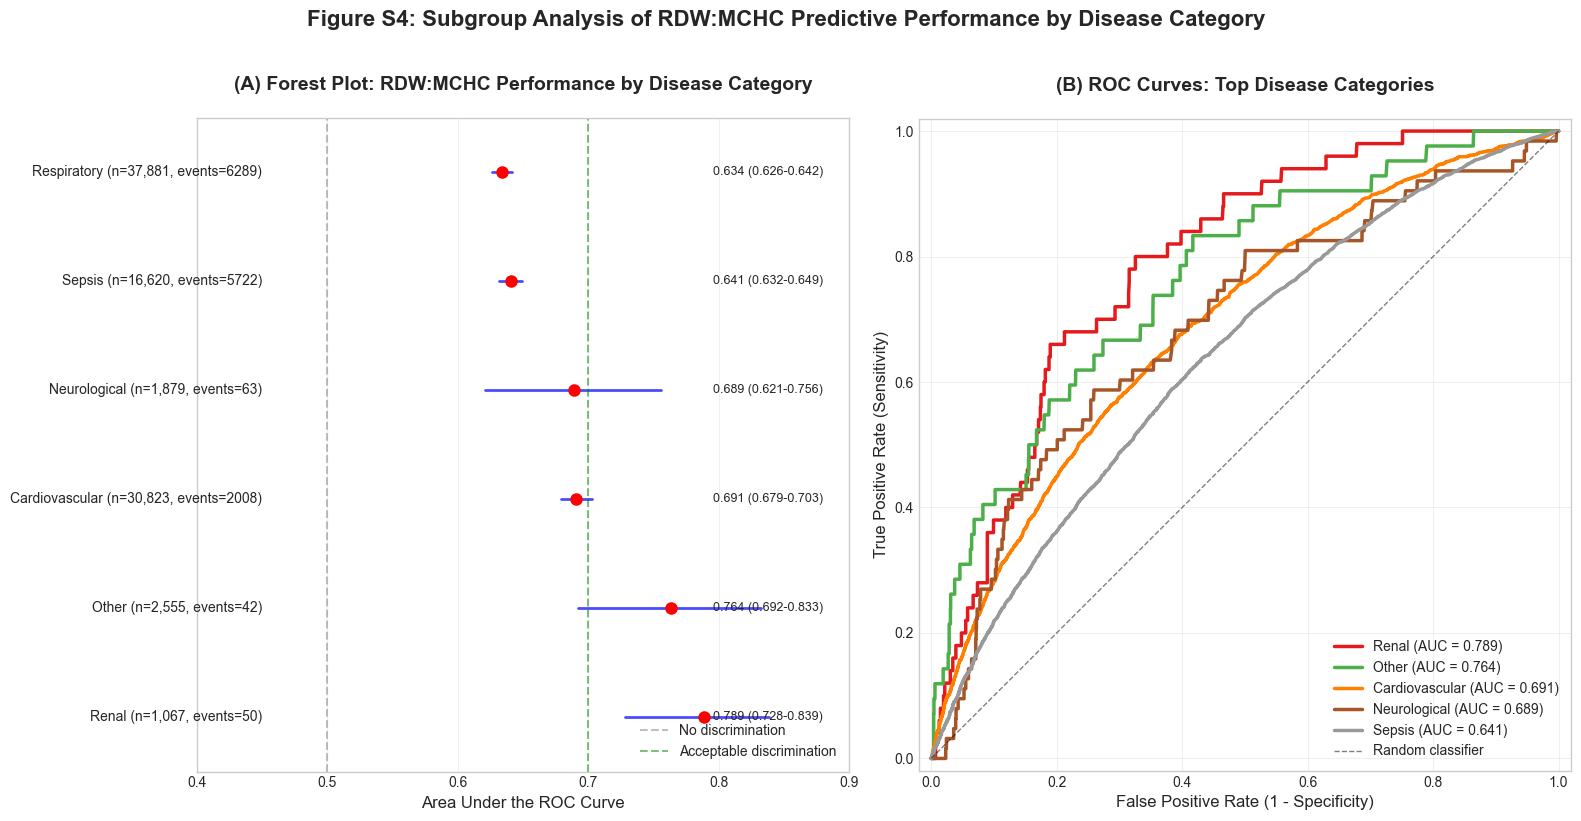


FIGURE S4 GENERATION COMPLETE
Disease categories analyzed: 6
Files saved:
  - figure_s4_disease_stratified.png
  - figure_s4_disease_stratified.pdf
  - figure_s4_numerical_results.csv

Top 3 performing disease categories:
  1. Renal: AUC = 0.789 (0.728-0.839)
  2. Other: AUC = 0.764 (0.692-0.833)
  3. Cardiovascular: AUC = 0.691 (0.679-0.703)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def calculate_roc_data(y_true, y_scores):
    """Calculate ROC curve data with confidence intervals"""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    
    # Bootstrap for CI
    n_bootstraps = 1000
    rng = np.random.RandomState(42)
    bootstrapped_aucs = []
    
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_scores), len(y_scores))
        if len(np.unique(y_true[indices])) < 2:
            continue
        try:
            bootstrap_auc = roc_auc_score(y_true[indices], y_scores[indices])
            bootstrapped_aucs.append(bootstrap_auc)
        except:
            continue
    
    ci_lower = np.percentile(bootstrapped_aucs, 2.5)
    ci_upper = np.percentile(bootstrapped_aucs, 97.5)
    
    return fpr, tpr, auc, ci_lower, ci_upper

def generate_figure_s4():
    """
    Generate Figure S4: Disease-Stratified Analysis
    (A) Forest plot of AUCs with 95% CIs
    (B) ROC curves for top disease categories
    """
    
    print("Generating Figure S4...")
    
    # Load the biomarker dataset with disease categories
    try:
        # First, check if we have the disease-merged dataset
        try:
            df_disease = pd.read_csv('disease_merged_dataset.csv')
            print(f"Loaded disease-merged dataset: {len(df_disease)} patients")
        except:
            # If not, create it
            print("Creating disease-merged dataset...")
            
            # Load biomarker data
            df_enhanced = pd.read_csv('cbc_with_ratios_dataset.csv')
            
            # Load disease stratification results if available
            try:
                disease_data = pd.read_csv('disease_stratification.csv')
                df_disease = df_enhanced.merge(disease_data, on='hadm_id', how='left')
            except:
                # Create disease categories from scratch
                import duckdb
                from pathlib import Path
                
                con = duckdb.connect()
                DATA_DIR = Path("/Users/dimitri/Desktop/indi/data/mimic-iv-3.1")
                p = lambda f: str(DATA_DIR / f)
                
                con.execute(f"""
                CREATE OR REPLACE VIEW diagnoses AS
                SELECT hadm_id, icd_version, icd_code
                FROM read_csv_auto('{p('hosp/diagnoses_icd.csv.gz')}');
                """)
                
                # Use simplified disease categorization
                disease_query = """
                WITH disease_flags AS (
                    SELECT 
                        hadm_id,
                        MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'J00' AND 'J99') 
                                  OR (icd_version='9' AND icd_code BETWEEN '460' AND '519') 
                            THEN 1 ELSE 0 END) AS respiratory,
                        MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'I00' AND 'I99') 
                                  OR (icd_version='9' AND icd_code BETWEEN '390' AND '459') 
                            THEN 1 ELSE 0 END) AS cardiovascular,
                        MAX(CASE WHEN (icd_version='10' AND (icd_code LIKE 'A41%' OR icd_code LIKE 'R65%')) 
                                  OR (icd_version='9' AND (icd_code LIKE '038%' OR icd_code LIKE '995.9%')) 
                            THEN 1 ELSE 0 END) AS sepsis,
                        MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'N00' AND 'N99') 
                                  OR (icd_version='9' AND icd_code BETWEEN '580' AND '629') 
                            THEN 1 ELSE 0 END) AS renal,
                        MAX(CASE WHEN (icd_version='10' AND icd_code BETWEEN 'G00' AND 'G99') 
                                  OR (icd_version='9' AND icd_code BETWEEN '320' AND '389') 
                            THEN 1 ELSE 0 END) AS neurological
                    FROM diagnoses
                    GROUP BY hadm_id
                )
                SELECT hadm_id,
                    CASE 
                        WHEN sepsis = 1 THEN 'Sepsis'
                        WHEN respiratory = 1 THEN 'Respiratory'
                        WHEN cardiovascular = 1 THEN 'Cardiovascular'
                        WHEN renal = 1 THEN 'Renal'
                        WHEN neurological = 1 THEN 'Neurological'
                        ELSE 'Other'
                    END AS primary_disease_category
                FROM disease_flags
                """
                
                disease_data = con.execute(disease_query).df()
                df_disease = df_enhanced.merge(disease_data, on='hadm_id', how='left')
            
            df_disease['primary_disease_category'] = df_disease['primary_disease_category'].fillna('Other')
            
    except Exception as e:
        print(f"ERROR loading data: {e}")
        return None
    
    # Ensure RDW:MCHC exists
    if 'rdw_to_mchc' not in df_disease.columns:
        if 'rdw' in df_disease.columns and 'mchc' in df_disease.columns:
            df_disease['rdw_to_mchc'] = df_disease['rdw'] / (df_disease['mchc'] + 1e-8)
        else:
            print("ERROR: RDW:MCHC ratio not found in dataset")
            return None
    
    # Calculate AUC for each disease category
    disease_results = []
    disease_counts = df_disease['primary_disease_category'].value_counts()
    
    for disease in disease_counts.index:
        if disease_counts[disease] < 100:  # Skip small groups
            continue
            
        disease_subset = df_disease[df_disease['primary_disease_category'] == disease]
        
        # Clean data
        clean_data = disease_subset[['rdw_to_mchc', 'mort_30d']].dropna()
        clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna()
        
        if len(clean_data) < 50 or clean_data['mort_30d'].nunique() < 2:
            continue
        
        try:
            # Calculate ROC data
            fpr, tpr, auc, ci_lower, ci_upper = calculate_roc_data(
                clean_data['mort_30d'].values,
                clean_data['rdw_to_mchc'].values
            )
            
            disease_results.append({
                'disease': disease,
                'n': len(clean_data),
                'events': int(clean_data['mort_30d'].sum()),
                'auc': auc,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'fpr': fpr,
                'tpr': tpr
            })
        except Exception as e:
            print(f"Error processing {disease}: {e}")
            continue
    
    # Sort by AUC
    disease_results = sorted(disease_results, key=lambda x: x['auc'], reverse=True)
    
    if len(disease_results) < 3:
        print("ERROR: Insufficient disease categories with valid data")
        return None
    
    # Create figure with two subplots
    fig = plt.figure(figsize=(16, 8))
    
    # ========== SUBPLOT A: Forest Plot ==========
    ax1 = plt.subplot(1, 2, 1)
    
    # Prepare data for forest plot
    y_positions = list(range(len(disease_results)))
    
    # Plot confidence intervals
    for i, result in enumerate(disease_results):
        # CI line
        ax1.plot([result['ci_lower'], result['ci_upper']], [i, i], 
                'b-', linewidth=2, alpha=0.7)
        
        # AUC point
        ax1.plot(result['auc'], i, 'ro', markersize=8)
        
        # Add text with N and events
        label = f"{result['disease']} (n={result['n']:,}, events={result['events']})"
        ax1.text(0.45, i, label, va='center', fontsize=10, ha='right')
    
    # Add reference lines
    ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='No discrimination')
    ax1.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Acceptable discrimination')
    
    # Formatting
    ax1.set_xlim([0.4, 0.9])
    ax1.set_ylim([-0.5, len(disease_results) - 0.5])
    ax1.set_xlabel('Area Under the ROC Curve', fontsize=12)
    ax1.set_yticks([])
    ax1.set_title('(A) Forest Plot: RDW:MCHC Performance by Disease Category', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.legend(loc='lower right', fontsize=10)
    
    # Add AUC values on the right
    for i, result in enumerate(disease_results):
        ax1.text(0.88, i, f"{result['auc']:.3f} ({result['ci_lower']:.3f}-{result['ci_upper']:.3f})", 
                va='center', fontsize=9, ha='right')
    
    # ========== SUBPLOT B: ROC Curves ==========
    ax2 = plt.subplot(1, 2, 2)
    
    # Plot ROC curves for top 5 disease categories (or all if less than 5)
    n_curves = min(5, len(disease_results))
    colors = plt.cm.Set1(np.linspace(0, 1, n_curves))
    
    for i in range(n_curves):
        result = disease_results[i]
        
        # Plot ROC curve
        ax2.plot(result['fpr'], result['tpr'], 
                color=colors[i], linewidth=2.5,
                label=f"{result['disease']} (AUC = {result['auc']:.3f})")
    
    # Add diagonal reference line
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='Random classifier')
    
    # Formatting
    ax2.set_xlim([-0.02, 1.02])
    ax2.set_ylim([-0.02, 1.02])
    ax2.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
    ax2.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
    ax2.set_title('(B) ROC Curves: Top Disease Categories', 
                  fontsize=14, fontweight='bold', pad=20)
    ax2.legend(loc='lower right', fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal')
    
    # Overall title
    fig.suptitle('Figure S4: Subgroup Analysis of RDW:MCHC Predictive Performance by Disease Category',
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig('figure_s4_disease_stratified.png', dpi=300, bbox_inches='tight')
    plt.savefig('figure_s4_disease_stratified.pdf', bbox_inches='tight')
    plt.show()
    
    # Save numerical results
    results_df = pd.DataFrame([{
        'Disease': r['disease'],
        'N': r['n'],
        'Events': r['events'],
        'AUC': r['auc'],
        'CI_Lower': r['ci_lower'],
        'CI_Upper': r['ci_upper']
    } for r in disease_results])
    
    results_df.to_csv('figure_s4_numerical_results.csv', index=False)
    
    print("\n" + "="*60)
    print("FIGURE S4 GENERATION COMPLETE")
    print("="*60)
    print(f"Disease categories analyzed: {len(disease_results)}")
    print(f"Files saved:")
    print("  - figure_s4_disease_stratified.png")
    print("  - figure_s4_disease_stratified.pdf")
    print("  - figure_s4_numerical_results.csv")
    
    print("\nTop 3 performing disease categories:")
    for i in range(min(3, len(disease_results))):
        r = disease_results[i]
        print(f"  {i+1}. {r['disease']}: AUC = {r['auc']:.3f} ({r['ci_lower']:.3f}-{r['ci_upper']:.3f})")
    
    return disease_results

# Execute the function
figure_s4_results = generate_figure_s4()

Generating Figure C1: Distribution of RDW/MCHC Ratio by Outcome...
Loaded dataset: 90946 patients
Clean data: 89916 patients after removing outliers
Survivors: 75940, Non-survivors: 13976


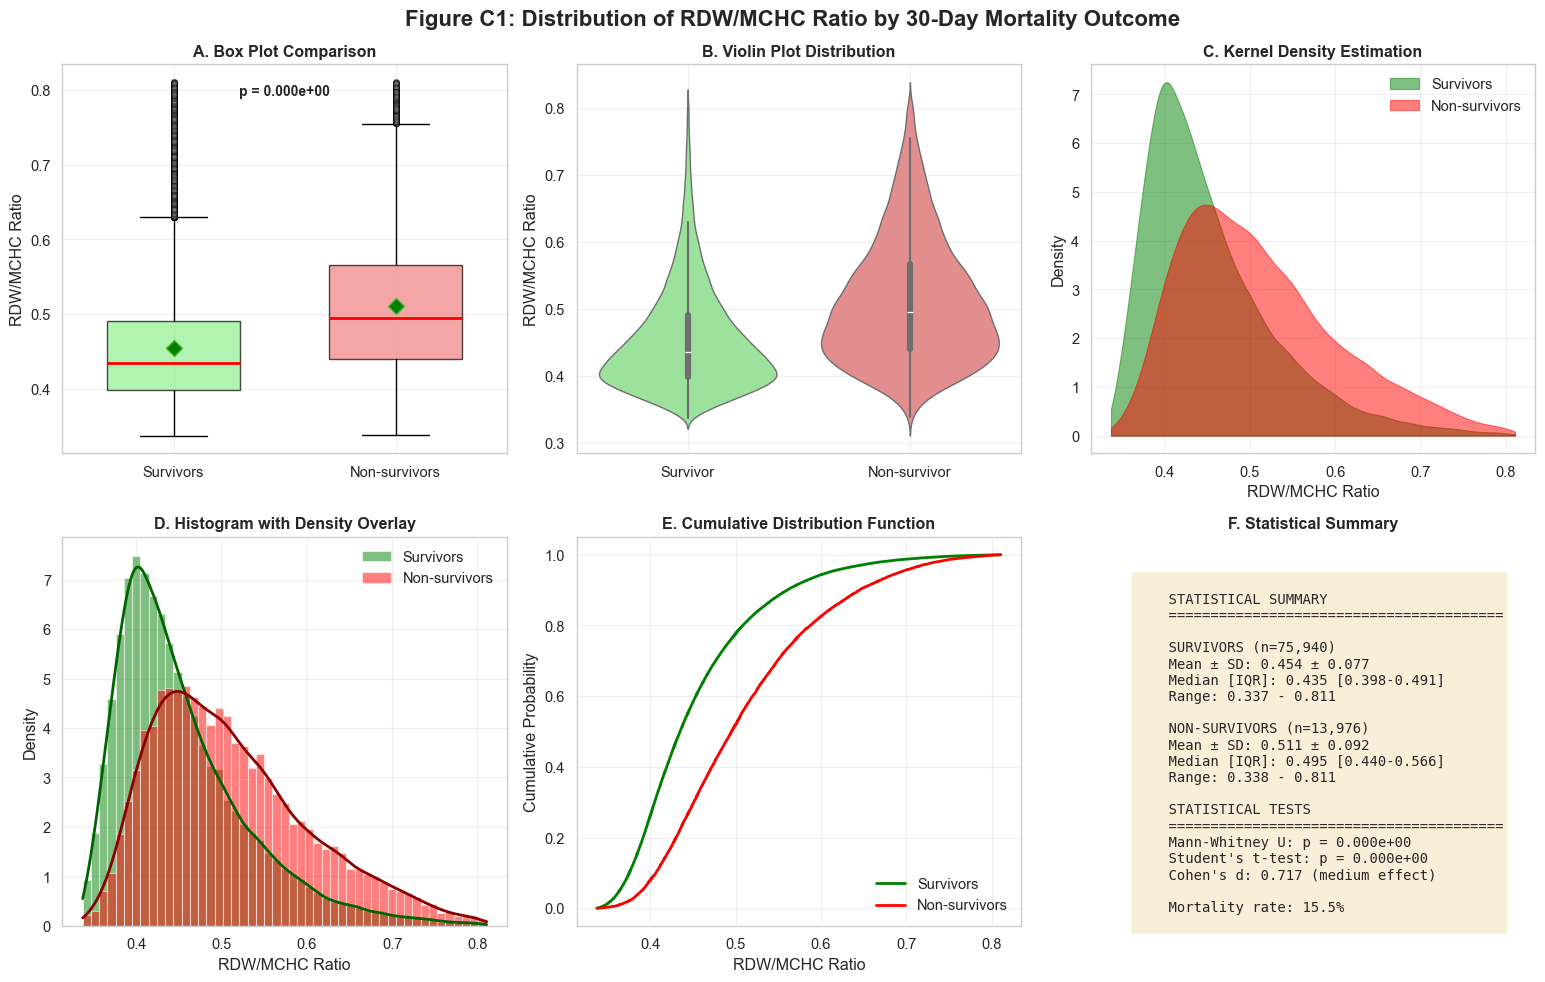


FIGURE C1 GENERATION COMPLETE
Files saved:
  - figure_c1_rdw_mchc_distribution.png
  - figure_c1_rdw_mchc_distribution.pdf

Key finding: RDW/MCHC is significantly higher in non-survivors
Effect size (Cohen's d): 0.717


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

def generate_figure_c1():
    """
    Generate Figure C1: Distribution of RDW/MCHC Ratio by Outcome
    Shows box plots, violin plots, and density distributions
    """
    
    print("Generating Figure C1: Distribution of RDW/MCHC Ratio by Outcome...")
    
    # Load the dataset
    try:
        df = pd.read_csv('cbc_with_ratios_dataset.csv')
        print(f"Loaded dataset: {len(df)} patients")
    except FileNotFoundError:
        print("ERROR: cbc_with_ratios_dataset.csv not found!")
        return None
    
    # Create RDW/MCHC ratio if not present
    if 'rdw_to_mchc' not in df.columns:
        if 'rdw' in df.columns and 'mchc' in df.columns:
            df['rdw_to_mchc'] = df['rdw'] / (df['mchc'] + 1e-8)
        else:
            print("ERROR: RDW and/or MCHC not found in dataset")
            return None
    
    # Clean data
    clean_df = df[['rdw_to_mchc', 'mort_30d']].dropna()
    clean_df = clean_df.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Remove extreme outliers (beyond 99.5th percentile)
    upper_limit = clean_df['rdw_to_mchc'].quantile(0.995)
    lower_limit = clean_df['rdw_to_mchc'].quantile(0.005)
    clean_df = clean_df[(clean_df['rdw_to_mchc'] >= lower_limit) & 
                        (clean_df['rdw_to_mchc'] <= upper_limit)]
    
    print(f"Clean data: {len(clean_df)} patients after removing outliers")
    
    # Separate by outcome
    survivors = clean_df[clean_df['mort_30d'] == 0]['rdw_to_mchc']
    non_survivors = clean_df[clean_df['mort_30d'] == 1]['rdw_to_mchc']
    
    print(f"Survivors: {len(survivors)}, Non-survivors: {len(non_survivors)}")
    
    # Statistical tests
    # Mann-Whitney U test (non-parametric)
    u_stat, p_value_mw = stats.mannwhitneyu(non_survivors, survivors, alternative='two-sided')
    
    # T-test (parametric)
    t_stat, p_value_t = stats.ttest_ind(non_survivors, survivors)
    
    # Cohen's d effect size
    pooled_std = np.sqrt(((len(survivors)-1)*survivors.var() + 
                          (len(non_survivors)-1)*non_survivors.var()) / 
                         (len(survivors)+len(non_survivors)-2))
    cohens_d = abs(non_survivors.mean() - survivors.mean()) / pooled_std
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(16, 10))
    
    # ========== SUBPLOT 1: Box Plot ==========
    ax1 = plt.subplot(2, 3, 1)
    
    box_data = [survivors, non_survivors]
    positions = [1, 2]
    
    bp = ax1.boxplot(box_data, positions=positions, widths=0.6,
                     patch_artist=True, showmeans=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     meanprops=dict(marker='D', markerfacecolor='green', markersize=8),
                     flierprops=dict(marker='o', markerfacecolor='gray', alpha=0.3, markersize=4))
    
    # Colour code by outcome
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax1.set_xticks(positions)
    ax1.set_xticklabels(['Survivors', 'Non-survivors'])
    ax1.set_ylabel('RDW/MCHC Ratio')
    ax1.set_title('A. Box Plot Comparison', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add statistical annotation
    y_max = ax1.get_ylim()[1]
    ax1.text(1.5, y_max * 0.95, f'p = {p_value_mw:.3e}', 
             ha='center', fontsize=10, fontweight='bold')
    
    # ========== SUBPLOT 2: Violin Plot ==========
    ax2 = plt.subplot(2, 3, 2)
    
    plot_df = pd.DataFrame({
        'RDW/MCHC': pd.concat([survivors, non_survivors]),
        'Outcome': ['Survivor']*len(survivors) + ['Non-survivor']*len(non_survivors)
    })
    
    vp = sns.violinplot(data=plot_df, x='Outcome', y='RDW/MCHC', 
                        palette=['lightgreen', 'lightcoral'],
                        inner='box', ax=ax2)
    
    ax2.set_xlabel('')
    ax2.set_ylabel('RDW/MCHC Ratio')
    ax2.set_title('B. Violin Plot Distribution', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # ========== SUBPLOT 3: Density Plot ==========
    ax3 = plt.subplot(2, 3, 3)
    
    # Calculate density curves
    density_survivors = stats.gaussian_kde(survivors)
    density_non_survivors = stats.gaussian_kde(non_survivors)
    
    # Create smooth x-axis for plotting
    x_range = np.linspace(clean_df['rdw_to_mchc'].min(), 
                         clean_df['rdw_to_mchc'].max(), 1000)
    
    ax3.fill_between(x_range, density_survivors(x_range), 
                     alpha=0.5, color='green', label='Survivors')
    ax3.fill_between(x_range, density_non_survivors(x_range), 
                     alpha=0.5, color='red', label='Non-survivors')
    
    ax3.set_xlabel('RDW/MCHC Ratio')
    ax3.set_ylabel('Density')
    ax3.set_title('C. Kernel Density Estimation', fontweight='bold')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    # ========== SUBPLOT 4: Histogram with Overlay ==========
    ax4 = plt.subplot(2, 3, 4)
    
    bins = np.linspace(clean_df['rdw_to_mchc'].min(), 
                      clean_df['rdw_to_mchc'].max(), 50)
    
    ax4.hist(survivors, bins=bins, alpha=0.5, color='green', 
             label='Survivors', density=True)
    ax4.hist(non_survivors, bins=bins, alpha=0.5, color='red', 
             label='Non-survivors', density=True)
    
    # Overlay density curves
    ax4.plot(x_range, density_survivors(x_range), 
             color='darkgreen', linewidth=2)
    ax4.plot(x_range, density_non_survivors(x_range), 
             color='darkred', linewidth=2)
    
    ax4.set_xlabel('RDW/MCHC Ratio')
    ax4.set_ylabel('Density')
    ax4.set_title('D. Histogram with Density Overlay', fontweight='bold')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3)
    
    # ========== SUBPLOT 5: Cumulative Distribution ==========
    ax5 = plt.subplot(2, 3, 5)
    
    # Sort values for CDF
    survivors_sorted = np.sort(survivors)
    non_survivors_sorted = np.sort(non_survivors)
    
    # Calculate cumulative probabilities
    surv_cdf = np.arange(1, len(survivors_sorted)+1) / len(survivors_sorted)
    non_surv_cdf = np.arange(1, len(non_survivors_sorted)+1) / len(non_survivors_sorted)
    
    ax5.plot(survivors_sorted, surv_cdf, color='green', 
             linewidth=2, label='Survivors')
    ax5.plot(non_survivors_sorted, non_surv_cdf, color='red', 
             linewidth=2, label='Non-survivors')
    
    ax5.set_xlabel('RDW/MCHC Ratio')
    ax5.set_ylabel('Cumulative Probability')
    ax5.set_title('E. Cumulative Distribution Function', fontweight='bold')
    ax5.legend(loc='lower right')
    ax5.grid(True, alpha=0.3)
    
    # ========== SUBPLOT 6: Statistical Summary ==========
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Create summary statistics table
    summary_stats = f"""
    STATISTICAL SUMMARY
    {'='*40}
    
    SURVIVORS (n={len(survivors):,})
    Mean ± SD: {survivors.mean():.3f} ± {survivors.std():.3f}
    Median [IQR]: {survivors.median():.3f} [{survivors.quantile(0.25):.3f}-{survivors.quantile(0.75):.3f}]
    Range: {survivors.min():.3f} - {survivors.max():.3f}
    
    NON-SURVIVORS (n={len(non_survivors):,})
    Mean ± SD: {non_survivors.mean():.3f} ± {non_survivors.std():.3f}
    Median [IQR]: {non_survivors.median():.3f} [{non_survivors.quantile(0.25):.3f}-{non_survivors.quantile(0.75):.3f}]
    Range: {non_survivors.min():.3f} - {non_survivors.max():.3f}
    
    STATISTICAL TESTS
    {'='*40}
    Mann-Whitney U: p = {p_value_mw:.3e}
    Student's t-test: p = {p_value_t:.3e}
    Cohen's d: {cohens_d:.3f} ({"small" if cohens_d < 0.5 else "medium" if cohens_d < 0.8 else "large"} effect)
    
    Mortality rate: {clean_df['mort_30d'].mean()*100:.1f}%
    """
    
    ax6.text(0.1, 0.9, summary_stats, transform=ax6.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax6.set_title('F. Statistical Summary', fontweight='bold')
    
    # Overall title
    fig.suptitle('Figure C1: Distribution of RDW/MCHC Ratio by 30-Day Mortality Outcome',
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig('figure_c1_rdw_mchc_distribution.png', dpi=300, bbox_inches='tight')
    plt.savefig('figure_c1_rdw_mchc_distribution.pdf', bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("FIGURE C1 GENERATION COMPLETE")
    print("="*60)
    print("Files saved:")
    print("  - figure_c1_rdw_mchc_distribution.png")
    print("  - figure_c1_rdw_mchc_distribution.pdf")
    print(f"\nKey finding: RDW/MCHC is significantly {"higher" if non_survivors.mean() > survivors.mean() else "lower"} in non-survivors")
    print(f"Effect size (Cohen's d): {cohens_d:.3f}")
    
    return clean_df

# Execute the function
figure_c1_data = generate_figure_c1()